# **Detección de ondas gravitacionales con Machine Learning**

Franco Cerino


# **Introducción**

En la actualidad, las técnicas de detección de ondas gravitacionales (GW) dependen de un modelado preciso de la GW que se quiere medir, que puede ser proveniente por ejemplo de la coalescencia de un sistema binario compacto. Los métodos típicos de detección utilizan la tecnica de matched-filtering (MF), donde se compara los datos obtenidos de una medición con un template de una GW. Estos métodos necesitan el conocimiento de la forma de la señal que se quiere encontrar y los parametros que la describen, como por ejemplo spines, masas y ubicacion en el cielo de un sistema binario de agujeros negros. Gracias a MF se ha podido detectar todas la señales medidas desde 2015. A pesar de esto, el método tiene limitaciones. MF puede no detectar señales con diferentes parámetros o formas a lo conocido o simulado. Ejemplos son supernovas y otras fuentes donde la estocasticidad esté envuelta.
Por lo tanto, en la actualidad se ha optado por desarrollar nuevas técnicas para identificar fuentes donde las GW no están modeladas y con esto permitir obtener nuevos conocimientos de física fundamental. Encontrar estas anomalías presentan un desafío y una oportunidad para la innovacion en el área de detección de ondas gravitacionales.

Previamente han sido explorados métodos de Deep Learning para detectar GW, pero en general se basan en técnicas supervisadas. Por construcción, estos métodos se basan en simulaciones realistas de la señal generada por un tipo de fuente específica y no hay garantía de generalizabilidad de un evento fuera de lo que se ha entrenado el modelo. Por ende también se opta un enfoque en métodos no supervisados para obtener capacidades de detección más alla de las simulaciones conocidas. Estos estudios se basan en aprender las características del background. Para definir si se ha encontrado una GW, los algoritmos utilizan el error al reconstruir la señal, a partir de la diferencia entre la señal original y la reconstruida por el modelo entrenado.

Este trabajo se origina a partir del Challenge NSF HDR A3D3: DETECTING ANOMALOUS GRAVITATIONAL WAVE SIGNALS (https://www.codabench.org/competitions/2626/), de donde se ha obtenido el dataset. La finalidad es desarrollar modelos para detectar GW donde la fuente no está modelada para realizar MF.

En este trabajo en particular se busca identificar fuentes de GW en general, buscando detectar patrones inusuales en las mediciones de LIGO, donde prepondera el ruido de los detectores.

Se comienza con un caso particular de deteccion de anomalías dentro del ruido medido, donde estas tienen la forma correspondiente a ondas gravitacionales emitidas por un sistema binario de agujeros negros.

Luego nos enfocamos en el caso general de deteccion de anomalías provenientes de fuentes no modeladas, donde buscamos ondas gravitacionales de cualquier tipo. A este enfoque lo llevamos a cabo con algoritmos no supervisados.

## Características de los datos

- **Muestreo de datos:** los datos se recopilan a 4096 Hz.

- **Segmentos de datos:** los datos se dividen en segmentos de 50 milisegundos cada uno. Dado que los datos se muestrean a 4096 Hz, cada segmento contiene 200 puntos de datos (50 milisegundos * 4096 muestras/segundo = 200 muestras).

- **Dimensiones de datos:** la dimensión de los datos de entrada es (N, 200, 2), donde N representa el número de segmentos de datos. La última dimensión de 2 corresponde a los interferómetros de LIGO en Hanford y Livingston.

- **Tipos de datos:**

  - **Provenientes de sistemas binarios**: este conjunto de datos incluye señales simuladas de agujeros negros binarios (BBH). Se trata de señales sintéticas que imitan las ondas gravitacionales que se esperan de los agujeros negros que orbitan y eventualmente se fusionan entre sí. Estas señales BBH simuladas se inyectan en ruido de fondo real para ayudar a entrenar los modelos.

  - **Background**: este conjunto de datos consta del ruido de fondo del período de observación O3a. Es importante destacar que se han eliminado de estos datos todos los eventos conocidos de ondas gravitacionales y otros excesos de energía.

Preprocesamiento de los datos del Challenge:

- Blanqueo (Whitening): Normaliza la potencia en todas las frecuencias para que cualquier exceso de potencia en una frecuencia específica sea más evidente (https://gwpy.github.io/docs/stable/examples/timeseries/whiten/).

- Filtro pasa banda (Bandpass): Aplica un filtro para las frecuencias de corte definidas (https://gwpy.github.io/docs/stable/signal/#gwpy.signal.filter_design.bandpass).

En el trabajo [GWAK: Gravitational-Wave Anomalous Knowledge
with Recurrent Autoencoders](https://arxiv.org/pdf/2309.11537) se usa pasa banda dentro del rango de frecuencias 30–1500 Hz para atenuar el ruido fuera del rango de mayor sensibilidad de los instrumentos de medición de GW.

# **Dataset**

In [ ]:
# importamos librerías a utilizar
import os
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn import metrics

!pip install optuna
import optuna

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from scipy.signal import spectrogram
from scipy.signal import stft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.1 MB/s eta 0:00:00


In [ ]:
# Cargar y normalizar datos
path = "" # data/transient_challenge/"
background = np.load(path + 'background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load(path + 'bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

In [ ]:
# dimensiones del dataset
background.shape, bbh.shape

((100000, 200, 2), (100000, 200, 2))

Graficamos mediciones de background solo y de background con ondas gravitacionales en ambos detectores.

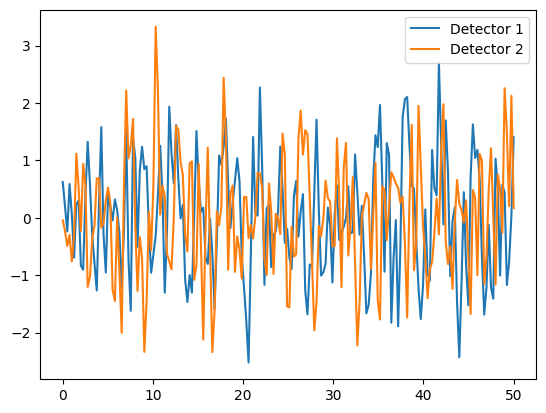

In [ ]:
sample = 1
t = np.linspace(0,50, 200)
plt.plot(t, background[sample,:,0], label = "Detector 1")
plt.plot(t, background[sample,:,1], label = "Detector 2")
plt.legend();

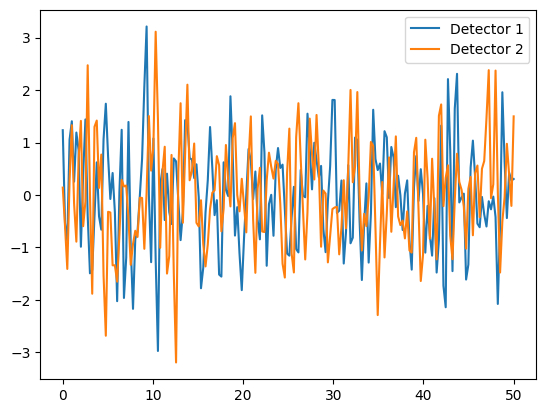

In [ ]:
sample = 45
plt.plot(t, background[sample,:,0], label = "Detector 1")
plt.plot(t, background[sample,:,1], label = "Detector 2")
plt.legend();

Creamos un dataset para realizar tareas de aprendizaje supervisado

In [ ]:
x_dataset = np.vstack((background, bbh))
y_dataset = np.concatenate((np.zeros(background.shape[0]), np.ones(bbh.shape[0])))
x_dataset.shape, y_dataset.shape

# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(x_dataset, y_dataset, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (160000, 200, 2) (40000, 200, 2)
y train/test shapes: (160000,) (40000,)


Para casos donde utilizamos un único modelo para aprender los datos de ambos detectores, concatenamos todas las mediciones en un único dataset.

In [ ]:
def mix_detector_series(x_train, y_train = None):
    x_train_detector1 = x_train[:,:,0]
    x_train_detector2 = x_train[:,:,1]
    x_train_mixed = np.vstack((x_train_detector1, x_train_detector2))
    if y_train is not None:
        y_train_mixed = np.hstack((y_train,y_train))
        print("y_train_mixed.shape:", y_train_mixed.shape)
        assert len(y_train_mixed.shape)==1
        return x_train_mixed, y_train_mixed
    else:
        return x_train_mixed

x_train_mixed, y_train_mixed = mix_detector_series(x_train, y_train)
x_test_mixed, y_test_mixed = mix_detector_series(x_test, y_test)

y_train_mixed.shape: (320000,)
y_train_mixed.shape: (80000,)


Realizamos un análisis de componentes principales del dataset de entrenamiento

In [ ]:
from sklearn.decomposition import PCA

n_components = 200
pca = PCA(n_components=n_components)
transformed_data = pca.fit_transform(x_train_mixed)

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

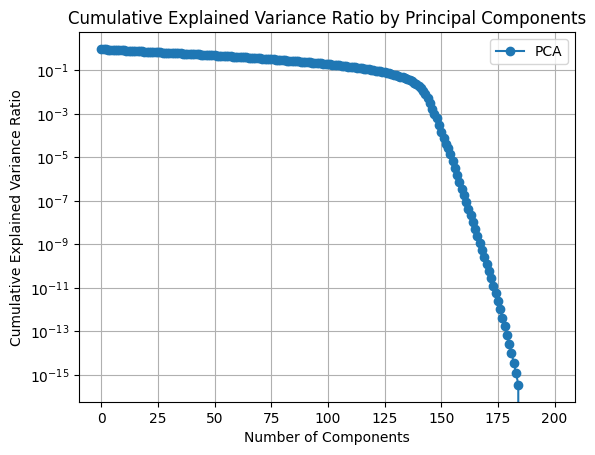

In [ ]:
plt.plot(1-cumulative_variance_ratio, marker='o', label="PCA")
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio by Principal Components')

plt.legend()
plt.yscale("log")
plt.grid()
plt.show()

### (Completar) PCA vs Bases Reducidas vs Encoder:

In [ ]:
pip install scikit-reducedmodel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.2/227.2 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 4.4 MB/s eta 0:00:00
  Created wheel for scikit-reducedmodel: filename=scikit_reducedmodel-1.1-py3-none-any.whl size=18194 sha256=b37b065b7cfef05ef0675a76f1c1ae270f608fa4c80a9223ad8940b2bbfb6dd1
  Stored in directory: /root/.cache/pip/wheels/d0/a3/48/0c3501e44e83dbf99b73131704f756f28e4aedbabadbfa8ed6
  Created wheel for gwtools: filename=gwtools-1.2.0-py3-none-any.whl size=37670 sha256=d97b9b76a6a6a02c64f531e748cb02eecfb12479a56029c805f942156eaa6d5c
  Stored in directory: /root/.cache/pip/wheels/75/46/9b/587b0b0d24d8a5001522a9af2f12c66d4d5c3b2b92235a8b86
Successfully built scikit-reducedmodel gwtools


In [ ]:
 x_train_mixed.shape

(320000, 200)

In [ ]:
from skreducedmodel.reducedbasis import ReducedBasis

aux = np.array([i for i in range(200)])
rb = ReducedBasis()
rb.fit(training_set = x_train_mixed,
        parameters = np.array([i for i in range(len(x_train_mixed))]),
        physical_points = aux
       )

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Reshape
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def build_autoencoder(input_shape, trial):
    # Hyperparameters to optimize
    filters_1 = trial.suggest_int('filters_1', 16, 64, step=16)
    filters_2 = trial.suggest_int('filters_2', 16, 64, step=16)
    kernel_size_1 = trial.suggest_int('kernel_size_1', 3, 7)
    kernel_size_2 = trial.suggest_int('kernel_size_2', 3, 7)
    latent_dim = trial.suggest_int('latent_dim', 8, 32, step=4)
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-4, 1e-2)

    # Encoder
    inputs = Input(shape=input_shape)
    x = Conv1D(filters=filters_1, kernel_size=kernel_size_1, activation='relu', padding='same')(inputs)
    x = Conv1D(filters=filters_2, kernel_size=kernel_size_2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    latent = Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = Dense(filters_2 * input_shape[0])(latent)
    x = Reshape((input_shape[0], filters_2))(x)
    x = Conv1DTranspose(filters=filters_2, kernel_size=kernel_size_2, activation='relu', padding='same')(x)
    outputs = Conv1DTranspose(filters=input_shape[-1], kernel_size=kernel_size_1, activation='sigmoid', padding='same')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate), loss='mse')
    return model

def objective(trial):
    input_shape = (200, 1)  # Time series of length 200, 1 feature
    model = build_autoencoder(input_shape, trial)

    # Training
    history = model.fit(train_data, train_data,
                        validation_data=(val_data, val_data),
                        epochs=10, batch_size=32, verbose=0)

    # Validation loss
    val_loss = history.history['val_loss'][-1]
    return val_loss

# Run Optuna study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Best parameters
print("Best parameters:", study.best_params)

# **Modelos supervisados**

Primero entrenamos modelos de baseline: KNN y Random Forest.

## KNN para cada detector

Considerando que cada detector puede tener sus propios patrones de ruido, creamos un modelo de aprendizaje para cada detector.

Utilizamos [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) de scikit-learn

In [ ]:
# Separate the two time series (feature dimensions)
x_train_detector1 = x_train[:, :, 0]
x_train_detector2 = x_train[:, :, 1]

x_test_detector1 = x_test[:, :, 0]
x_test_detector2 = x_test[:, :, 1]

In [ ]:
# train a KNN model for each detector
knn_detector1 = KNeighborsClassifier(n_neighbors=3)
knn_detector1.fit(x_train_detector1, y_train)
knn_detector2 = KNeighborsClassifier(n_neighbors=3)
knn_detector2.fit(x_train_detector2, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred_detector1 = knn_detector1.predict(x_test_detector1)
y_pred_detector2 = knn_detector2.predict(x_test_detector2)

In [ ]:
# Combine predictions: True if both classifiers give 1
y_combined_pred = (y_pred_detector1 == 1) & (y_pred_detector2 == 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_combined_pred)
print(f"Combined classifier accuracy: {accuracy:.2f}")

Combined classifier accuracy: 0.93


Confusion Matrix:
[[18440  1553]
 [ 1134 18873]]
Combined classifier accuracy: 0.93


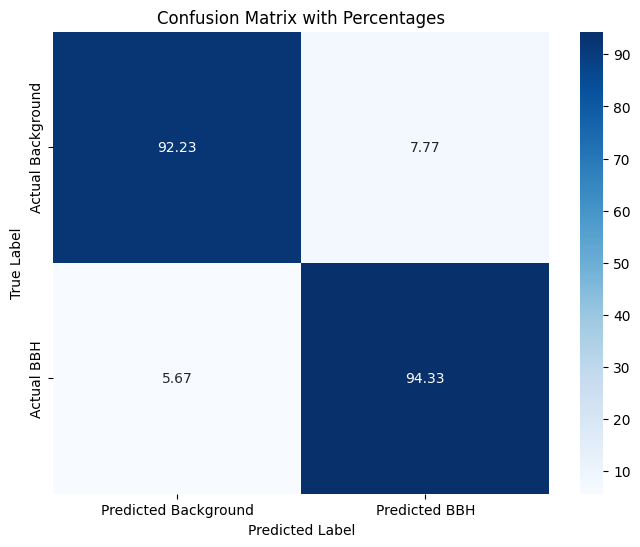

Combined classifier accuracy: 0.93


In [ ]:
y_combined_pred = y_combined_pred.astype(int)  # Convert boolean array to integer (0 or 1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_combined_pred)
accuracy = accuracy_score(y_test, y_combined_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"Combined classifier accuracy: {accuracy:.2f}")

# Normalize the confusion matrix by dividing each value by the row sum
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['Predicted Background', 'Predicted BBH'],
            yticklabels=['Actual Background', 'Actual BBH'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

# Print the accuracy
accuracy = accuracy_score(y_test, y_combined_pred)
print(f"Combined classifier accuracy: {accuracy:.2f}")

## Un único KNN para todo el dataset

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(x_train_mixed, y_train_mixed)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = knn.predict(x_test_mixed)

Confusion Matrix:
[[29670 10316]
 [ 1118 38896]]
classifier accuracy: 0.86


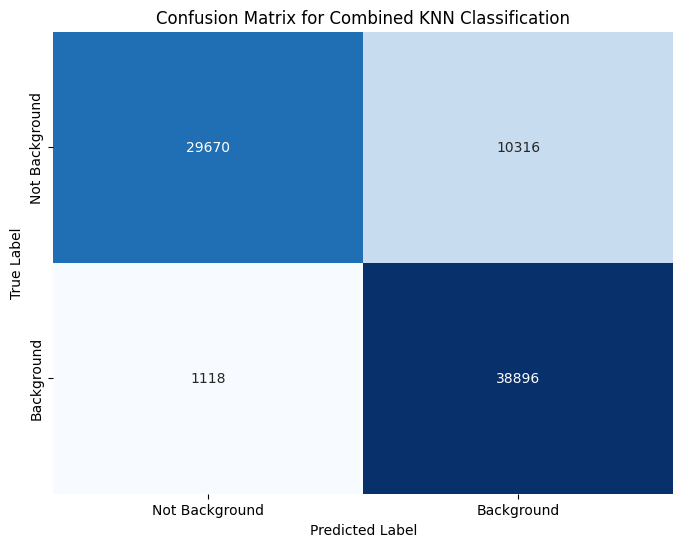

In [ ]:
y_pred = y_pred.astype(int)  # Convert boolean array to integer (0 or 1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_mixed, y_pred)
accuracy = accuracy_score(y_test_mixed, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"classifier accuracy: {accuracy:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Background', 'Background'],
            yticklabels=['Not Background', 'Background'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Combined KNN Classification')
plt.show()

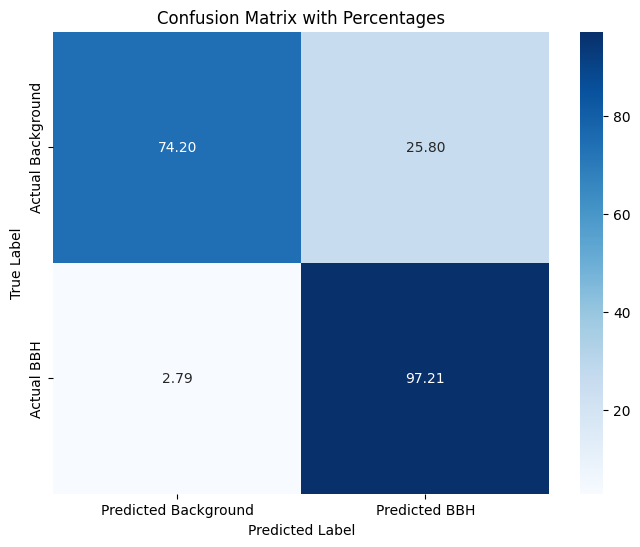

In [ ]:
# Normalize the confusion matrix by dividing each value by the row sum
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['Predicted Background', 'Predicted BBH'],
            yticklabels=['Actual Background', 'Actual BBH'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

Accuracy mejora de 0.86 a 0.93 tomando 1 KNN para cada detector.

## Random Forest para cada detector

Para dividir los nodos en las características más informativas, necesitamos definir una función objetivo que queremos optimizar. Queremos maximizar la ganancia de información en cada división.

In [ ]:
# train a KNN model for each detector
rf_detector1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_detector1.fit(x_train_detector1, y_train)

rf_detector2 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_detector2.fit(x_train_detector2, y_train)

# Get predictions from each classifier
y_pred_detector1 = rf_detector1.predict(x_test_detector1)
y_pred_detector2 = rf_detector2.predict(x_test_detector2)

# Combine predictions: True if both classifiers give 1
y_combined_pred = (y_pred_detector1 == 1) & (y_pred_detector2 == 1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_combined_pred)
print(f"Combined classifier accuracy: {accuracy:.2f}")

Combined classifier accuracy: 0.83


Confusion Matrix:
[[19967    26]
 [ 6716 13291]]
Combined classifier accuracy: 0.83


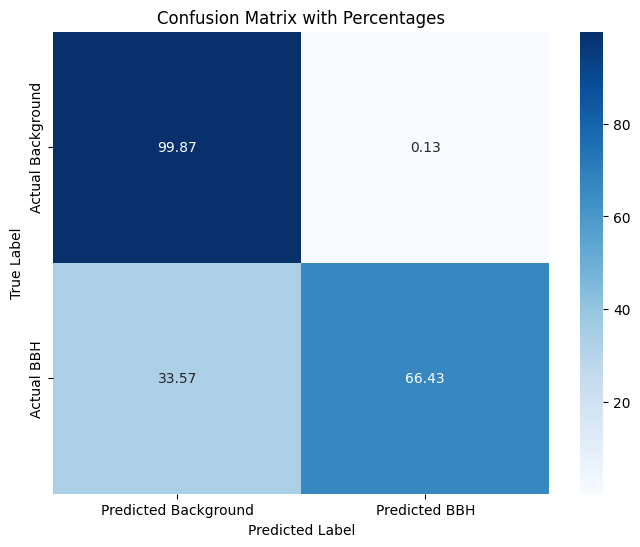

Combined classifier accuracy: 0.83


In [ ]:
y_combined_pred = y_combined_pred.astype(int)  # Convert boolean array to integer (0 or 1)
conf_matrix = confusion_matrix(y_test, y_combined_pred)
print("Confusion Matrix:")
print(conf_matrix)

# Normalize the confusion matrix by dividing each value by the row sum
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['Predicted Background', 'Predicted BBH'],
            yticklabels=['Actual Background', 'Actual BBH'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

## Un único Random Forest para todo el dataset


Utilizamos [RandomForestClassifier](https://scikit-learn.org/1.5/modules/generated/sklearn.ensemble.RandomForestClassifier.html) de scikit-learn.

Toma decisiones en base a la minimizacion del coeficiente de Gini (default en sklearn). Cada feature es un tiempo de la serie temporal.

https://towardsdatascience.com/entropy-how-decision-trees-make-decisions-2946b9c18c8

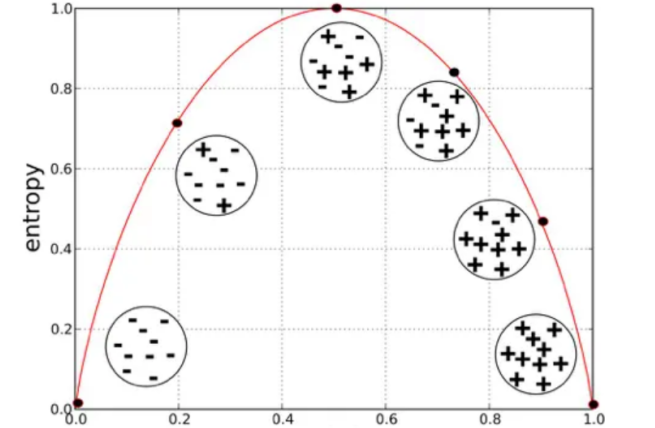

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train_mixed, y_train_mixed)
y_pred = rf.predict(x_test_mixed)

In [ ]:
from sklearn.tree import plot_tree
rf1 = RandomForestClassifier(n_estimators=2, random_state=42)
rf1.fit(x_train_mixed, y_train_mixed)

# Extract a single tree from the Random Forest
tree = rf1.estimators_[0]

plt.figure(figsize=(20, 10))
plot_tree(tree, feature_names=[str(i) for i in range(200)], class_names=[str(0),str(1)], filled=True, rounded=True)
plt.show()

Confusion Matrix:
[[38422  1564]
 [ 7961 32053]]
classifier accuracy: 0.88


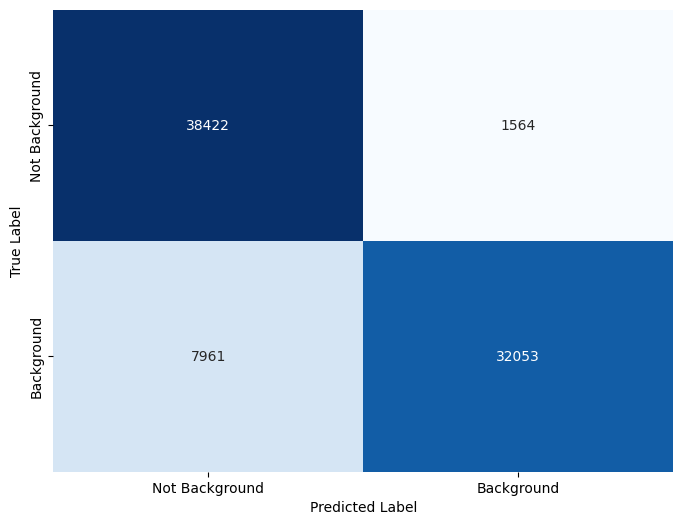

In [ ]:
y_pred = y_pred.astype(int)  # Convert boolean array to integer (0 or 1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_mixed, y_pred)
accuracy = accuracy_score(y_test_mixed, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"classifier accuracy: {accuracy:.2f}")
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Background', 'Background'],
            yticklabels=['Not Background', 'Background'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

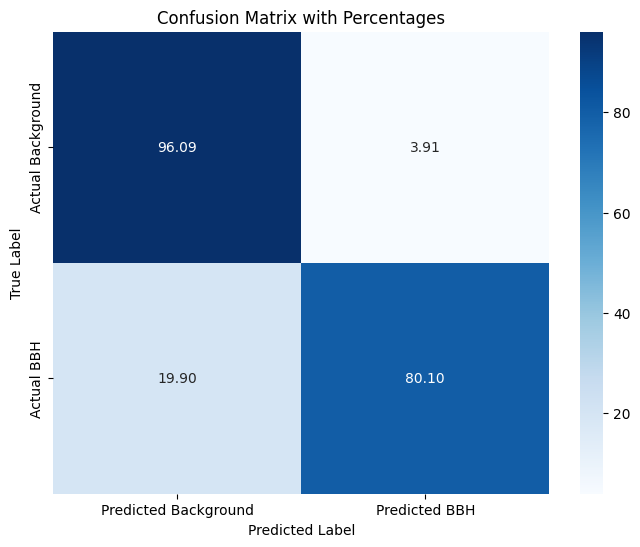

In [ ]:
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the confusion matrix with percentages
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_percent, annot=True, fmt=".2f", cmap='Blues',
            xticklabels=['Predicted Background', 'Predicted BBH'],
            yticklabels=['Actual Background', 'Actual BBH'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix with Percentages')
plt.show()

## Red convolucional 1D

Realizamos una búsqueda de hiperparámetros de diferentes redes convolucionales, teniendo en cuenta la arquitectura de la red.

Utilizamos la librería Optuna para la búsqueda.

[I 2024-11-14 22:37:52,928] A new study created in memory with name: no-name-8a2c6808-d279-440e-ad2f-73a6e3de9df8


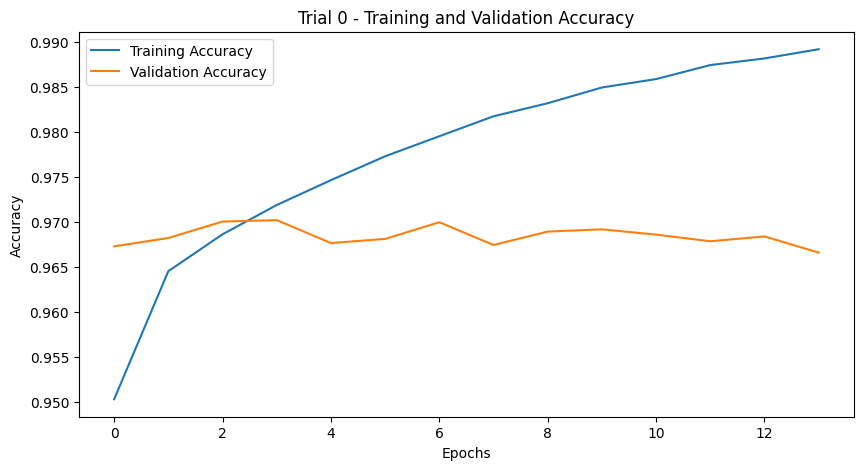

[I 2024-11-14 22:45:39,118] Trial 0 finished with value: 0.9702000021934509 and parameters: {'n_filters': 64, 'n_layers': 1, 'kernel_size': 6, 'dense_units': 245, 'dropout_rate': 0.1287170488827043, 'learning_rate': 0.0015105640160372534}. Best is trial 0 with value: 0.9702000021934509.


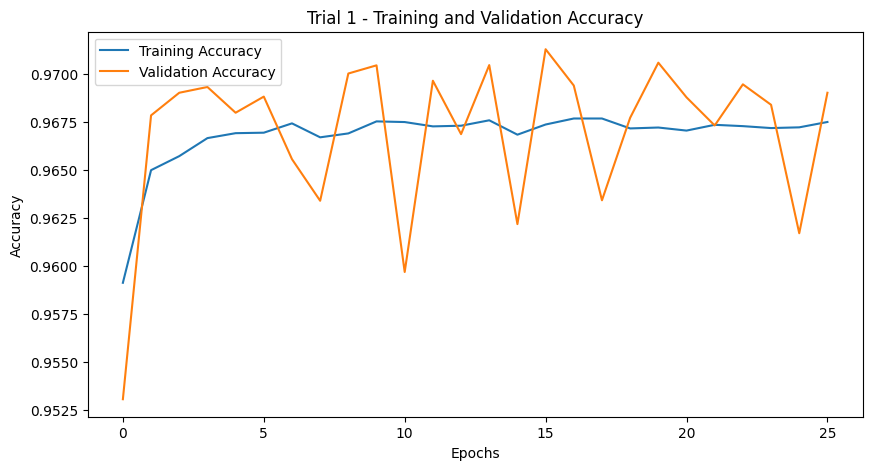

[I 2024-11-14 23:00:08,564] Trial 1 finished with value: 0.971262514591217 and parameters: {'n_filters': 64, 'n_layers': 3, 'kernel_size': 5, 'dense_units': 123, 'dropout_rate': 0.0635677548553526, 'learning_rate': 0.007483862096667576}. Best is trial 1 with value: 0.971262514591217.


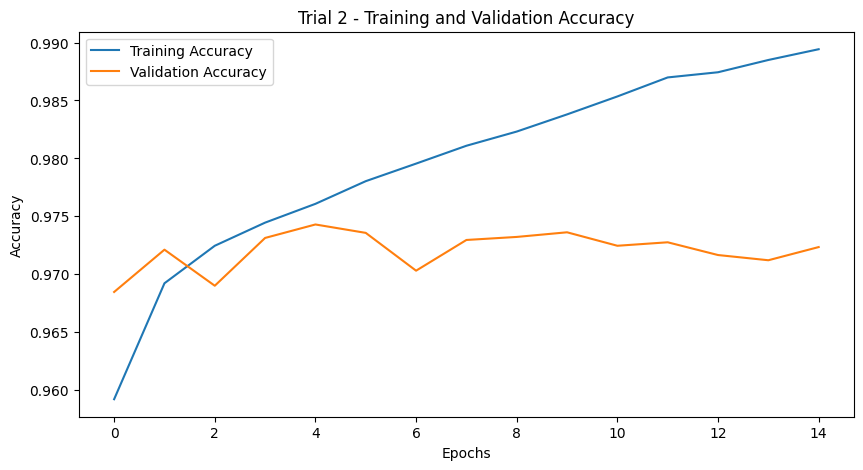

[I 2024-11-14 23:07:49,814] Trial 2 finished with value: 0.9743000268936157 and parameters: {'n_filters': 32, 'n_layers': 2, 'kernel_size': 5, 'dense_units': 94, 'dropout_rate': 0.18190820666176605, 'learning_rate': 0.00040736046107320067}. Best is trial 2 with value: 0.9743000268936157.


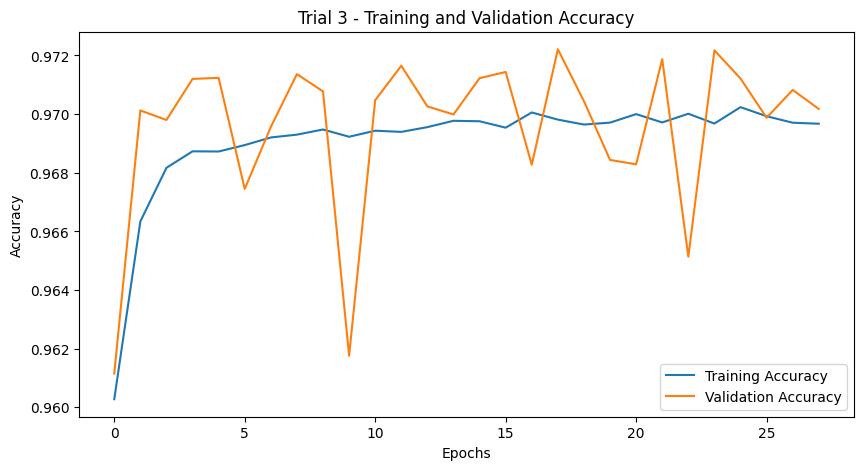

[I 2024-11-14 23:22:23,411] Trial 3 finished with value: 0.9722124934196472 and parameters: {'n_filters': 32, 'n_layers': 3, 'kernel_size': 6, 'dense_units': 225, 'dropout_rate': 0.05151481677356504, 'learning_rate': 0.005288613013557675}. Best is trial 2 with value: 0.9743000268936157.


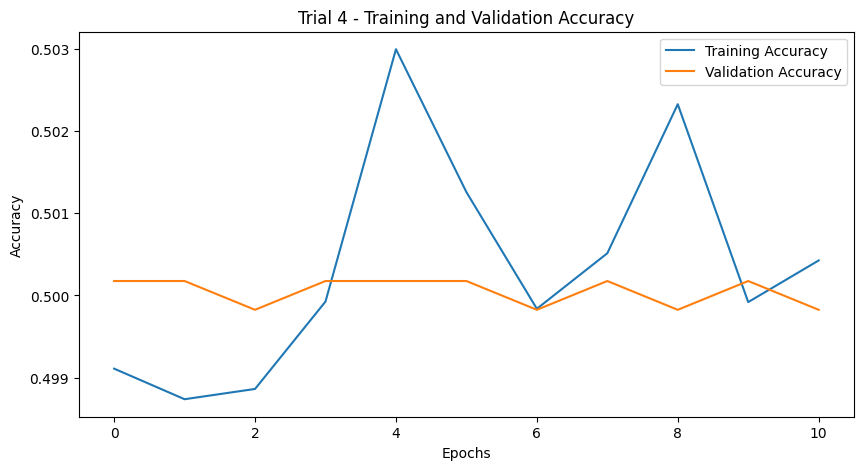

[I 2024-11-14 23:27:48,163] Trial 4 finished with value: 0.5001749992370605 and parameters: {'n_filters': 64, 'n_layers': 2, 'kernel_size': 5, 'dense_units': 161, 'dropout_rate': 0.19398969293335544, 'learning_rate': 0.0070877169556580214}. Best is trial 2 with value: 0.9743000268936157.


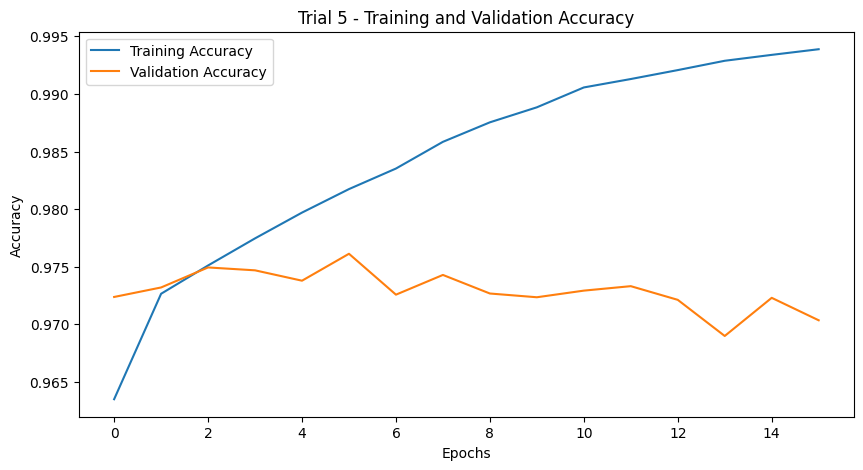

[I 2024-11-14 23:35:57,992] Trial 5 finished with value: 0.9761250019073486 and parameters: {'n_filters': 32, 'n_layers': 2, 'kernel_size': 6, 'dense_units': 192, 'dropout_rate': 0.08496240267651886, 'learning_rate': 0.000948076237055915}. Best is trial 5 with value: 0.9761250019073486.


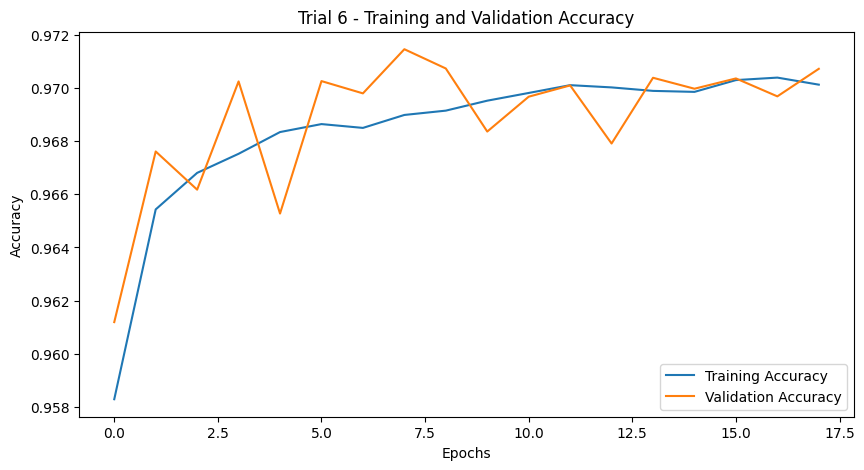

[I 2024-11-14 23:45:53,206] Trial 6 finished with value: 0.9714624881744385 and parameters: {'n_filters': 64, 'n_layers': 3, 'kernel_size': 5, 'dense_units': 243, 'dropout_rate': 0.09105637546463427, 'learning_rate': 0.005718604871050766}. Best is trial 5 with value: 0.9761250019073486.


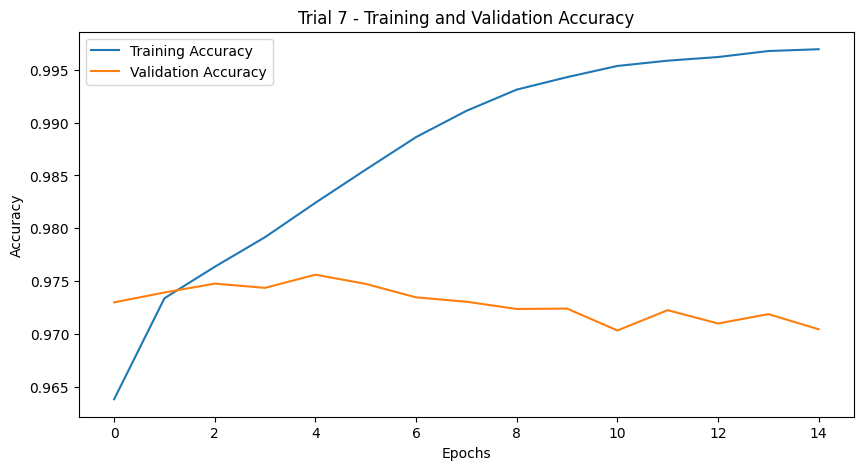

[I 2024-11-14 23:54:36,080] Trial 7 finished with value: 0.975600004196167 and parameters: {'n_filters': 128, 'n_layers': 2, 'kernel_size': 6, 'dense_units': 180, 'dropout_rate': 0.06995267733730097, 'learning_rate': 0.00048629855373923537}. Best is trial 5 with value: 0.9761250019073486.


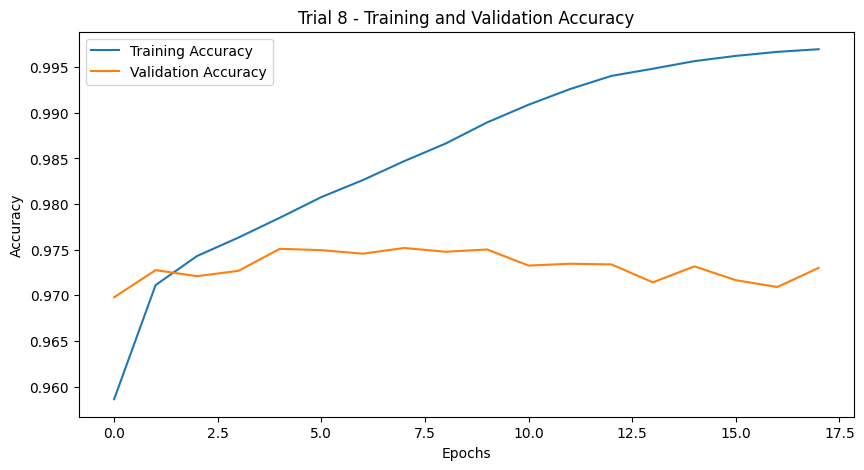

[I 2024-11-15 00:04:57,654] Trial 8 finished with value: 0.9751874804496765 and parameters: {'n_filters': 32, 'n_layers': 2, 'kernel_size': 6, 'dense_units': 179, 'dropout_rate': 0.08462442090227548, 'learning_rate': 0.00021038431654759208}. Best is trial 5 with value: 0.9761250019073486.


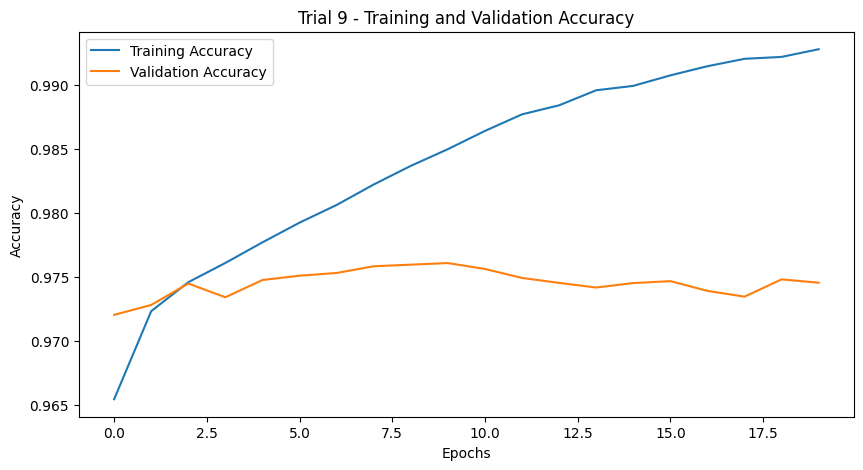

[I 2024-11-15 00:16:57,617] Trial 9 finished with value: 0.9760749936103821 and parameters: {'n_filters': 64, 'n_layers': 3, 'kernel_size': 7, 'dense_units': 130, 'dropout_rate': 0.18920934131162953, 'learning_rate': 0.0006378299054035639}. Best is trial 5 with value: 0.9761250019073486.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Suggest values for hyperparameters
    n_filters = trial.suggest_categorical('n_filters', [32, 64, 128])
    n_layers = trial.suggest_int('n_layers', 1, 3)
    kernel_size = trial.suggest_int('kernel_size', 3, 7)
    dense_units = trial.suggest_int('dense_units', 64, 256)
    dropout_rate = trial.suggest_float('dropout_rate', 0.05, 0.2)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)

    # Build the model
    model = Sequential()
    model.add(Conv1D(filters=n_filters,
                     kernel_size=kernel_size,
                     activation='relu',
                     input_shape=(x_train_mixed.shape[1], 1 ))
             )
    model.add(MaxPooling1D(pool_size=2))

    for _ in range(n_layers - 1):
        model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=2))

    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Set up EarlyStopping callback
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

    # Train the model with EarlyStopping
    history = model.fit(
        x_train_mixed, y_train_mixed,
        epochs=50,
        batch_size=32,
        validation_data=(x_test_mixed, y_test_mixed),
        callbacks=[early_stopping],
        verbose=0
    )

    # Track training and validation accuracy across epochs for plotting
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Plot the accuracy for this trial
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Trial {trial.number} - Training and Validation Accuracy')
    plt.legend()
    plt.show()
    plt.pause(0.1)  # Pause to allow the plot to display

    # Get the best validation accuracy and set it as the objective value
    val_accuracy_best = max(val_accuracy)
    return val_accuracy_best

# Run Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

Entrenamos el mejor modelo y utilizamos más epochs.

In [ ]:
kwargs = {'n_filters': 32,
          'n_layers': 2,
          'kernel_size': 6,
          'dense_units': 192,
          'dropout_rate': 0.08496240267651886,
          'learning_rate': 0.000948076237055915
          }

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'trial' is not defined

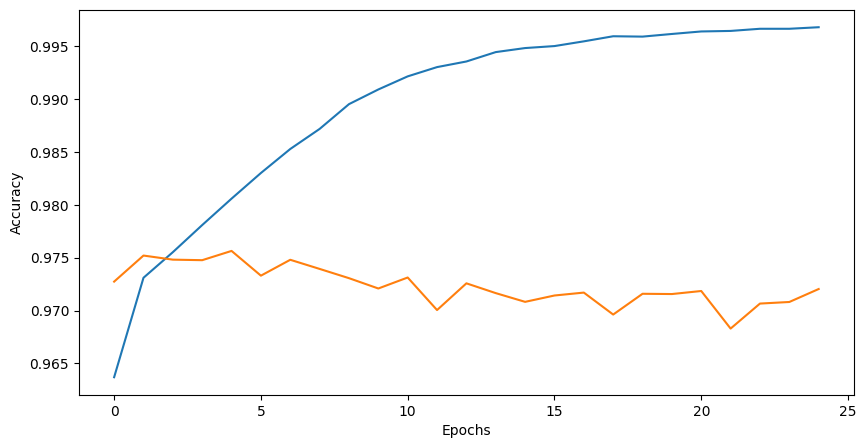

In [ ]:
n_filters = kwargs["n_filters"]
n_layers = kwargs["n_layers"]
kernel_size = kwargs["kernel_size"]
dense_units = kwargs["dense_units"]
dropout_rate = kwargs["dropout_rate"]
learning_rate = kwargs["learning_rate"]

# Build the model
model = Sequential()
model.add(Conv1D(filters=n_filters,
                  kernel_size=kernel_size,
                  activation='relu',
                  input_shape=(x_train_mixed.shape[1], 1 ))
          )
model.add(MaxPooling1D(pool_size=2))

for _ in range(n_layers - 1):
    model.add(Conv1D(filters=n_filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(dense_units, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Set up EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(
    x_train_mixed, y_train_mixed,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_mixed, y_test_mixed),
    callbacks=[early_stopping],
    verbose=0
)

# Track training and validation accuracy across epochs for plotting
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

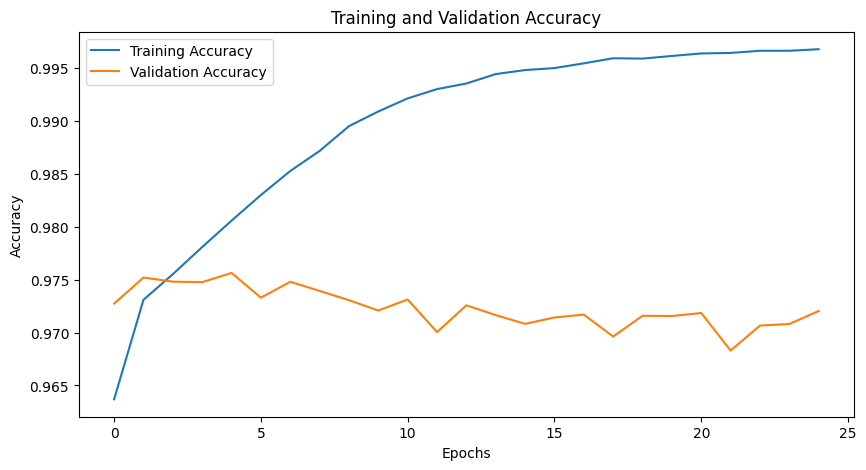

In [ ]:
# Plot the accuracy for this trial
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title(f'Training and Validation Accuracy')
plt.legend()
plt.show()
plt.pause(0.1)  # Pause to allow the plot to display

# Get the best validation accuracy and set it as the objective value
val_accuracy_best = max(val_accuracy)

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


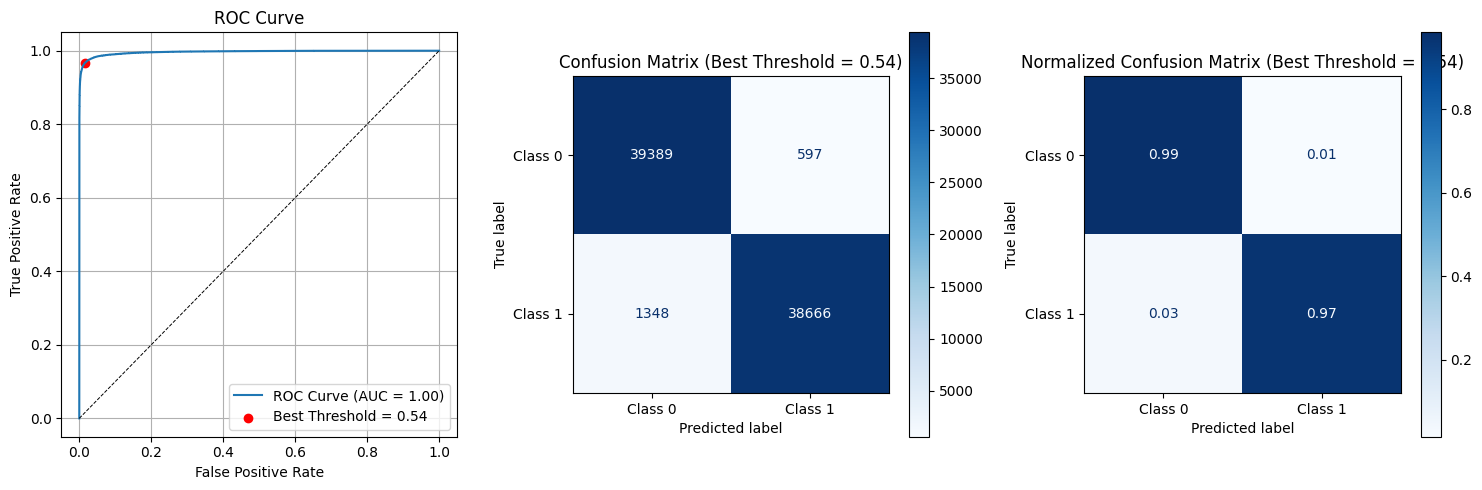

In [ ]:
# Predict probabilities on the test set
y_pred_proba = model.predict(x_test_mixed).ravel()

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_mixed, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find the best threshold (Youden's J statistic)
j_scores = tpr - fpr
best_threshold_index = j_scores.argmax()
best_threshold = thresholds[best_threshold_index]

# Plot ROC Curve
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', linewidth=1.5)
plt.plot([0, 1], [0, 1], 'k--', linewidth=0.7)
plt.scatter(fpr[best_threshold_index], tpr[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)

# Apply the best threshold to get binary predictions
y_pred_binary = (y_pred_proba >= best_threshold).astype(int)

# Compute both regular and normalized confusion matrices
cm = confusion_matrix(y_test_mixed, y_pred_binary)
cm_normalized = confusion_matrix(y_test_mixed, y_pred_binary, normalize="true")

# Plot Regular Confusion Matrix
plt.subplot(1, 3, 2)
ConfusionMatrixDisplay(cm, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title(f'Confusion Matrix (Best Threshold = {best_threshold:.2f})')

# Plot Normalized Confusion Matrix
plt.subplot(1, 3, 3)
ConfusionMatrixDisplay(cm_normalized, display_labels=["Class 0", "Class 1"]).plot(cmap="Blues", values_format=".2f", ax=plt.gca())
plt.title(f'Normalized Confusion Matrix (Best Threshold = {best_threshold:.2f})')

plt.tight_layout()
plt.show()

## YOLO

Utilizamos la última versión de You Only Look Once (YOLO).

Basado en CNN.

Estado del arte en 2024 (v11).

https://github.com/ultralytics/ultralytics

https://docs.ultralytics.com/models/yolo11/



Arquitectura de YOLO:

- 24 capas convolucionales

- 4 capas max-pooling layers

- 2 capas fully connected

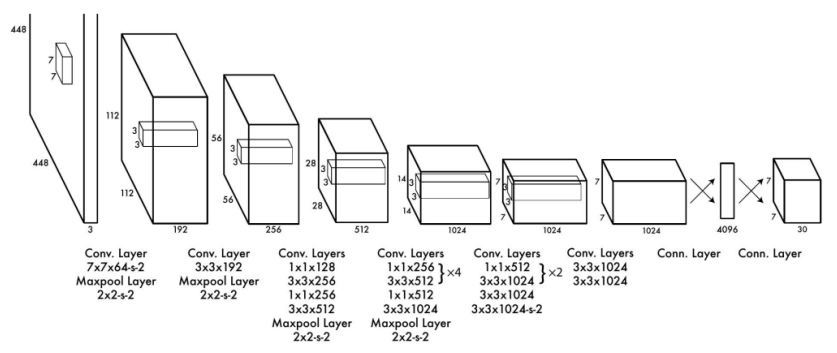

### Construyendo espectrogramas para YOLO

In [ ]:
# load data asnd normalize it
path = "data/transient_challenge/"
background = np.load(path + 'background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load(path + 'bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load(path + 'sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

In [ ]:
mixed_background = np.vstack((background[:,:,0], background[:,:,1]))
mixed_bbh = np.vstack((bbh[:,:,0], bbh[:,:,1]))
mixed_sglf = np.vstack((sglf[:,:,0], sglf[:,:,1]))

mixed_background_train, mixed_background_test = train_test_split(mixed_background, test_size=0.20, random_state=42)
mixed_bbh_train, mixed_bbh_test = train_test_split(mixed_bbh, test_size=0.20, random_state=42)
mixed_sglf_train, mixed_sglf_test = train_test_split(mixed_sglf, test_size=0.20, random_state=42)

In [ ]:
# Function to create and save spectrograms with minimal plot elements
def create_spectrogram(signal, sample_rate, output_path):
    # Calculate the spectrogram
    f, t, Sxx = spectrogram(signal, fs=sample_rate, nperseg=128, noverlap=64)

    # Convert to decibel scale
    Sxx_db = 10 * np.log10(Sxx + 1e-10)  # Adding a small constant to avoid log(0)

    # Plot and save the spectrogram as an image without axis details
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(t, f, Sxx_db, shading='gouraud', cmap='viridis')

    # Remove all axes, labels, and colorbars
    plt.axis('off')

    # Save the figure with minimal whitespace
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# Main function to process and save the dataset as spectrogram images
def save_spectrogram_images(data, labels, sample_rate, output_dir='dataset_spectrograms'):
    for i, (signal, label) in enumerate(zip(data, labels)):
        # Define the output directory based on the label (class)
        label_dir = os.path.join(output_dir, f'{label}')
        os.makedirs(label_dir, exist_ok=True)

        # Define the file name and path for each spectrogram image
        output_path = os.path.join(label_dir, f'{label}_{i}.png')

        # Create and save the spectrogram
        create_spectrogram(signal, sample_rate, output_path)
        print(f'Saved spectrogram for sample {i} at {output_path}')

In [ ]:
# label es la clase de la imagen

sets = [
    ("bbh",        "anomaly_detection_data/train", mixed_bbh_test[:5000]),
    ("bbh",        "anomaly_detection_data/test",  mixed_bbh_test[:5000]),
    ("background", "anomaly_detection_data/train", mixed_background_train[:5000]),
    ("background", "anomaly_detection_data/test",  mixed_background_test[:5000])
]
    #("sglf",       "train", mixed_sglf_train),
    #("sglf",       "test",  mixed_sglf_test)

for label, output_dir, data in sets:
    save_spectrogram_images(data,
                            labels = [label for i in range(len(data))],
                            sample_rate = 4096,
                            output_dir = output_dir
                           )

Saved spectrogram for sample 0 at anomaly_detection_data/test/background/background_0.png
Saved spectrogram for sample 1 at anomaly_detection_data/test/background/background_1.png
Saved spectrogram for sample 2 at anomaly_detection_data/test/background/background_2.png
Saved spectrogram for sample 3 at anomaly_detection_data/test/background/background_3.png
Saved spectrogram for sample 4 at anomaly_detection_data/test/background/background_4.png
Saved spectrogram for sample 5 at anomaly_detection_data/test/background/background_5.png
Saved spectrogram for sample 6 at anomaly_detection_data/test/background/background_6.png
Saved spectrogram for sample 7 at anomaly_detection_data/test/background/background_7.png
Saved spectrogram for sample 8 at anomaly_detection_data/test/background/background_8.png
Saved spectrogram for sample 9 at anomaly_detection_data/test/background/background_9.png
Saved spectrogram for sample 10 at anomaly_detection_data/test/background/background_10.png
Saved sp

In [ ]:
def display_saved_spectrogram(image_path):
    # Load the image
    img = mpimg.imread(image_path)

    # Display the image
    plt.figure(figsize=(10, 6))
    plt.imshow(img, aspect='auto', cmap='viridis')
    plt.axis('off')  # Hide axes for a clean view
    plt.show()

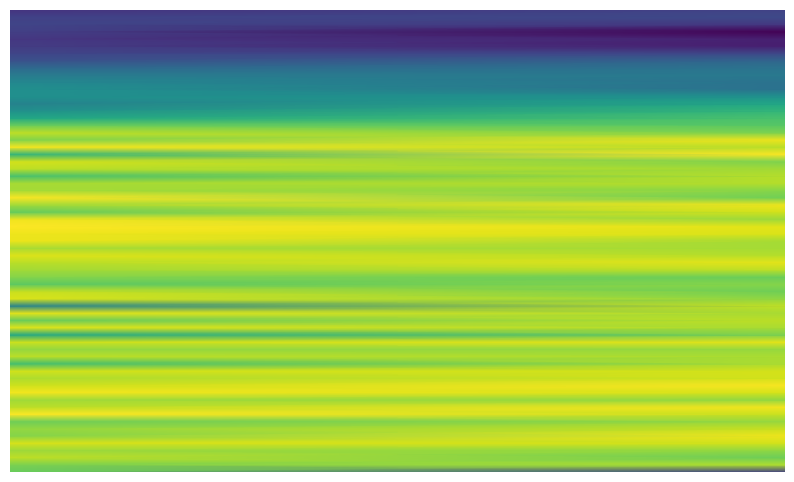

In [ ]:
image_path = 'anomaly_detection_data/test/background/background_999.png'
display_saved_spectrogram(image_path)

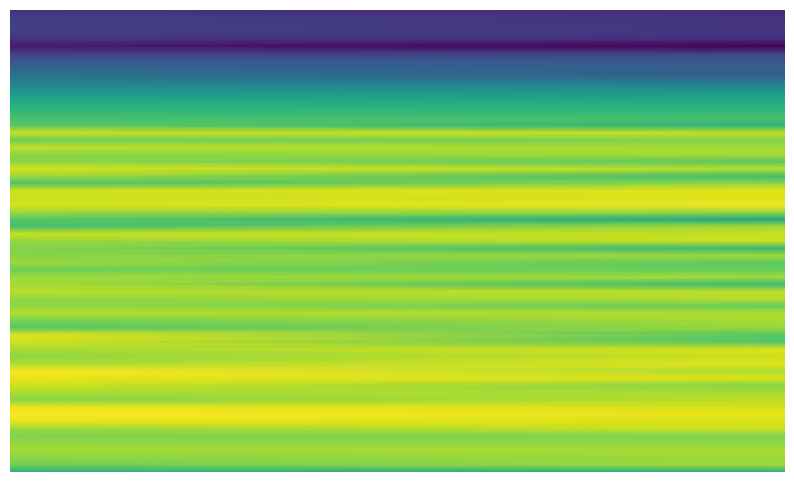

In [ ]:
image_path = 'anomaly_detection_data/test/background/background_144.png'
display_saved_spectrogram(image_path)

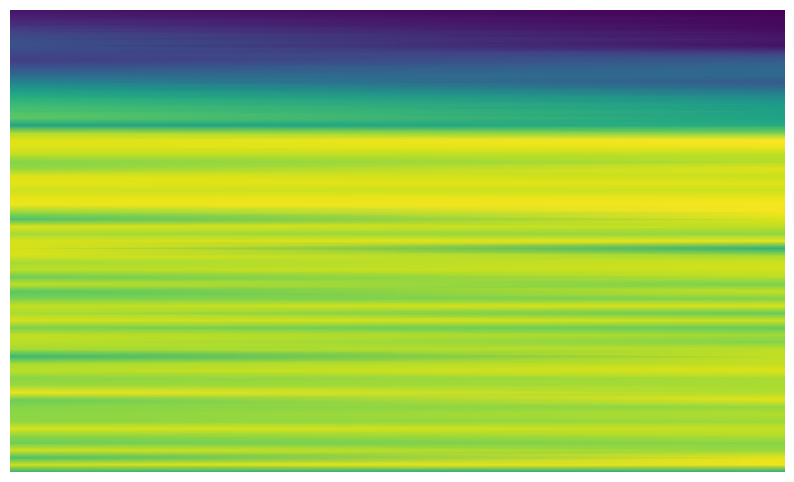

In [ ]:
image_path = 'anomaly_detection_data/test/bbh/bbh_123.png'
display_saved_spectrogram(image_path)

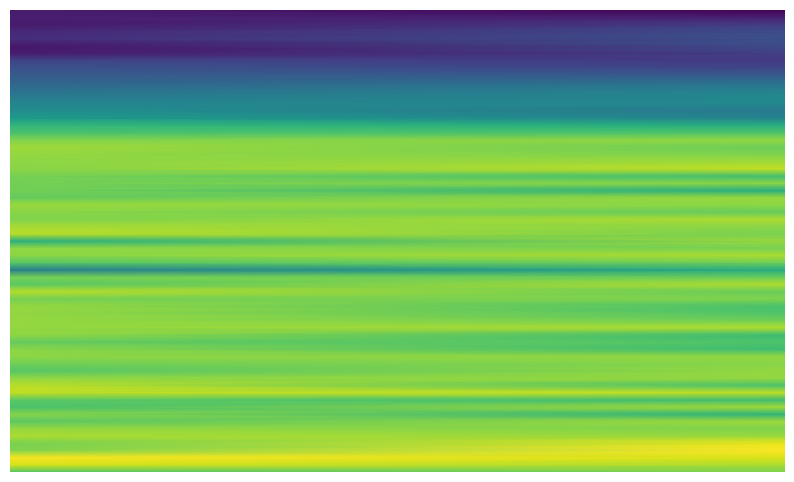

In [ ]:
image_path = 'anomaly_detection_data/test/bbh/bbh_999.png'
display_saved_spectrogram(image_path)

### Entrenando YOLO

In [ ]:
!pip install ultralitycs
from ultralytics import YOLO

In [ ]:
# Load a model
model = YOLO("yolo11n-cls.pt")  # load a pretrained model (recommended for training)

# imgsz: Target image size for training.
# All images are resized to this dimension before being fed into the model.
# Affects model accuracy and computational complexity.

# Train the model
results = model.train(data="anomaly_detection_data", epochs=10, imgsz=640)

Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=anomaly_detection_data, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /home/fcerino/anomaly_detection_data/train... 2000 images, 0 cor
val: Scanning /home/fcerino/anomaly_detection_data/test... 2000 images, 0 corrup

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train5
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10         0G      0.644         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:52<00:0

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


       2/10         0G     0.5001         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [02:32<00:0

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


       3/10         0G     0.4262         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [01:24<00:0

                   all      0.895          1



      Epoch    GPU_mem       loss  Instances       Size


       4/10         0G     0.3814         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:49<00:0

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


       5/10         0G     0.3511         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:49<00:0

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


       6/10         0G     0.3355         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


       7/10         0G     0.3113         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:49<00:0

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


       8/10         0G     0.2961         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


       9/10         0G     0.2794         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G     0.2706         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:49<00:0

                   all      0.949          1



10 epochs completed in 0.540 hours.
Optimizer stripped from runs/classify/train5/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train5/weights/best.pt, 3.2MB

Validating runs/classify/train5/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /home/fcerino/anomaly_detection_data/train... found 2000 images in 2 classes ✅ 
val: None...
test: /home/fcerino/anomaly_detection_data/test... found 2000 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:45<00:0


                   all      0.948          1
Speed: 0.0ms preprocess, 8.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train5


In [ ]:
# Load a model
model = YOLO("yolo11n-cls.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="anomaly_detection_data", epochs=100, imgsz=64)

Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=anomaly_detection_data, epochs=100, time=None, patience=100, batch=16, imgsz=64, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train7, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /home/fcerino/anomaly_detection_data/train... 2000 images, 0 cor
val: Scanning /home/fcerino/anomaly_detection_data/test... 2000 images, 0 corrup

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 64 train, 64 val
Using 0 dataloader workers
Logging results to runs/classify/train7
Starting training for 100 epochs...

      Epoch    GPU_mem       loss  Instances       Size


      1/100         0G     0.7373         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.726          1



      Epoch    GPU_mem       loss  Instances       Size


      2/100         0G     0.5923         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.846          1



      Epoch    GPU_mem       loss  Instances       Size


      3/100         0G     0.5451         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.837          1



      Epoch    GPU_mem       loss  Instances       Size


      4/100         0G     0.4821         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.899          1



      Epoch    GPU_mem       loss  Instances       Size


      5/100         0G     0.4459         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


      6/100         0G     0.4481         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


      7/100         0G     0.4073         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.888          1



      Epoch    GPU_mem       loss  Instances       Size


      8/100         0G      0.394         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.911          1



      Epoch    GPU_mem       loss  Instances       Size


      9/100         0G     0.3833         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.916          1



      Epoch    GPU_mem       loss  Instances       Size


     10/100         0G      0.397         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     11/100         0G     0.3632         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     12/100         0G     0.3671         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all        0.9          1



      Epoch    GPU_mem       loss  Instances       Size


     13/100         0G     0.3227         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all       0.91          1



      Epoch    GPU_mem       loss  Instances       Size


     14/100         0G     0.3557         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.909          1



      Epoch    GPU_mem       loss  Instances       Size


     15/100         0G     0.3446         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     16/100         0G     0.3433         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all       0.91          1



      Epoch    GPU_mem       loss  Instances       Size


     17/100         0G     0.3444         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


     18/100         0G     0.3471         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


     19/100         0G     0.3451         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.922          1



      Epoch    GPU_mem       loss  Instances       Size


     20/100         0G     0.3136         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.925          1



      Epoch    GPU_mem       loss  Instances       Size


     21/100         0G     0.3357         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


     22/100         0G     0.3124         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


     23/100         0G     0.3167         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.916          1



      Epoch    GPU_mem       loss  Instances       Size


     24/100         0G     0.3273         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


     25/100         0G     0.3235         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


     26/100         0G     0.3024         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


     27/100         0G     0.3021         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


     28/100         0G     0.3267         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


     29/100         0G     0.3073         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all       0.92          1



      Epoch    GPU_mem       loss  Instances       Size


     30/100         0G     0.2953         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


     31/100         0G     0.3071         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


     32/100         0G     0.2996         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     33/100         0G     0.3069         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.929          1



      Epoch    GPU_mem       loss  Instances       Size


     34/100         0G     0.3114         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


     35/100         0G     0.2949         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.937          1



      Epoch    GPU_mem       loss  Instances       Size


     36/100         0G     0.3058         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     37/100         0G     0.3001         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


     38/100         0G     0.2731         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


     39/100         0G     0.2995         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.923          1



      Epoch    GPU_mem       loss  Instances       Size


     40/100         0G     0.2935         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.934          1



      Epoch    GPU_mem       loss  Instances       Size


     41/100         0G     0.2977         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     42/100         0G     0.3058         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all       0.93          1



      Epoch    GPU_mem       loss  Instances       Size


     43/100         0G     0.3049         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     44/100         0G     0.2917         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


     45/100         0G     0.2758         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


     46/100         0G      0.279         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


     47/100         0G     0.2644         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


     48/100         0G      0.276         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


     49/100         0G     0.2691         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     50/100         0G     0.2903         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


     51/100         0G     0.2809         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


     52/100         0G     0.2831         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     53/100         0G     0.2844         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


     54/100         0G     0.2832         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


     55/100         0G     0.2691         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


     56/100         0G     0.2856         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.943          1



      Epoch    GPU_mem       loss  Instances       Size


     57/100         0G     0.2715         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


     58/100         0G     0.2917         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


     59/100         0G      0.284         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     60/100         0G     0.2636         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     61/100         0G     0.2758         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     62/100         0G     0.2713         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


     63/100         0G      0.262         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     64/100         0G     0.2675         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     65/100         0G     0.2784         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


     66/100         0G     0.2573         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


     67/100         0G     0.2641         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.946          1



      Epoch    GPU_mem       loss  Instances       Size


     68/100         0G     0.2701         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


     69/100         0G      0.277         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     70/100         0G     0.2698         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     71/100         0G     0.2666         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


     72/100         0G     0.2778         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     73/100         0G     0.2608         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


     74/100         0G     0.2676         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:17<00:0

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     75/100         0G     0.2592         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     76/100         0G     0.2701         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     77/100         0G     0.2504         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


     78/100         0G     0.2743         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


     79/100         0G     0.2599         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     80/100         0G     0.2398         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all       0.95          1



      Epoch    GPU_mem       loss  Instances       Size


     81/100         0G     0.2591         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


     82/100         0G     0.2444         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.949          1



      Epoch    GPU_mem       loss  Instances       Size


     83/100         0G     0.2661         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     84/100         0G     0.2457         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


     85/100         0G     0.2531         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


     86/100         0G     0.2672         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


     87/100         0G     0.2366         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     88/100         0G     0.2573         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     89/100         0G     0.2571         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     90/100         0G     0.2424         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:15<00:0

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     91/100         0G     0.2491         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


     92/100         0G     0.2622         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


     93/100         0G     0.2694         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


     94/100         0G     0.2472         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


     95/100         0G     0.2512         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.957          1



      Epoch    GPU_mem       loss  Instances       Size


     96/100         0G     0.2574         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


     97/100         0G     0.2456         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.953          1



      Epoch    GPU_mem       loss  Instances       Size


     98/100         0G     0.2494         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.955          1



      Epoch    GPU_mem       loss  Instances       Size


     99/100         0G     0.2518         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


    100/100         0G     0.2495         16         64: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:16<00:0

                   all      0.956          1



100 epochs completed in 1.047 hours.
Optimizer stripped from runs/classify/train7/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train7/weights/best.pt, 3.2MB

Validating runs/classify/train7/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /home/fcerino/anomaly_detection_data/train... found 2000 images in 2 classes ✅ 
val: None...
test: /home/fcerino/anomaly_detection_data/test... found 2000 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:15<00:0


                   all      0.957          1
Speed: 0.0ms preprocess, 0.3ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train7


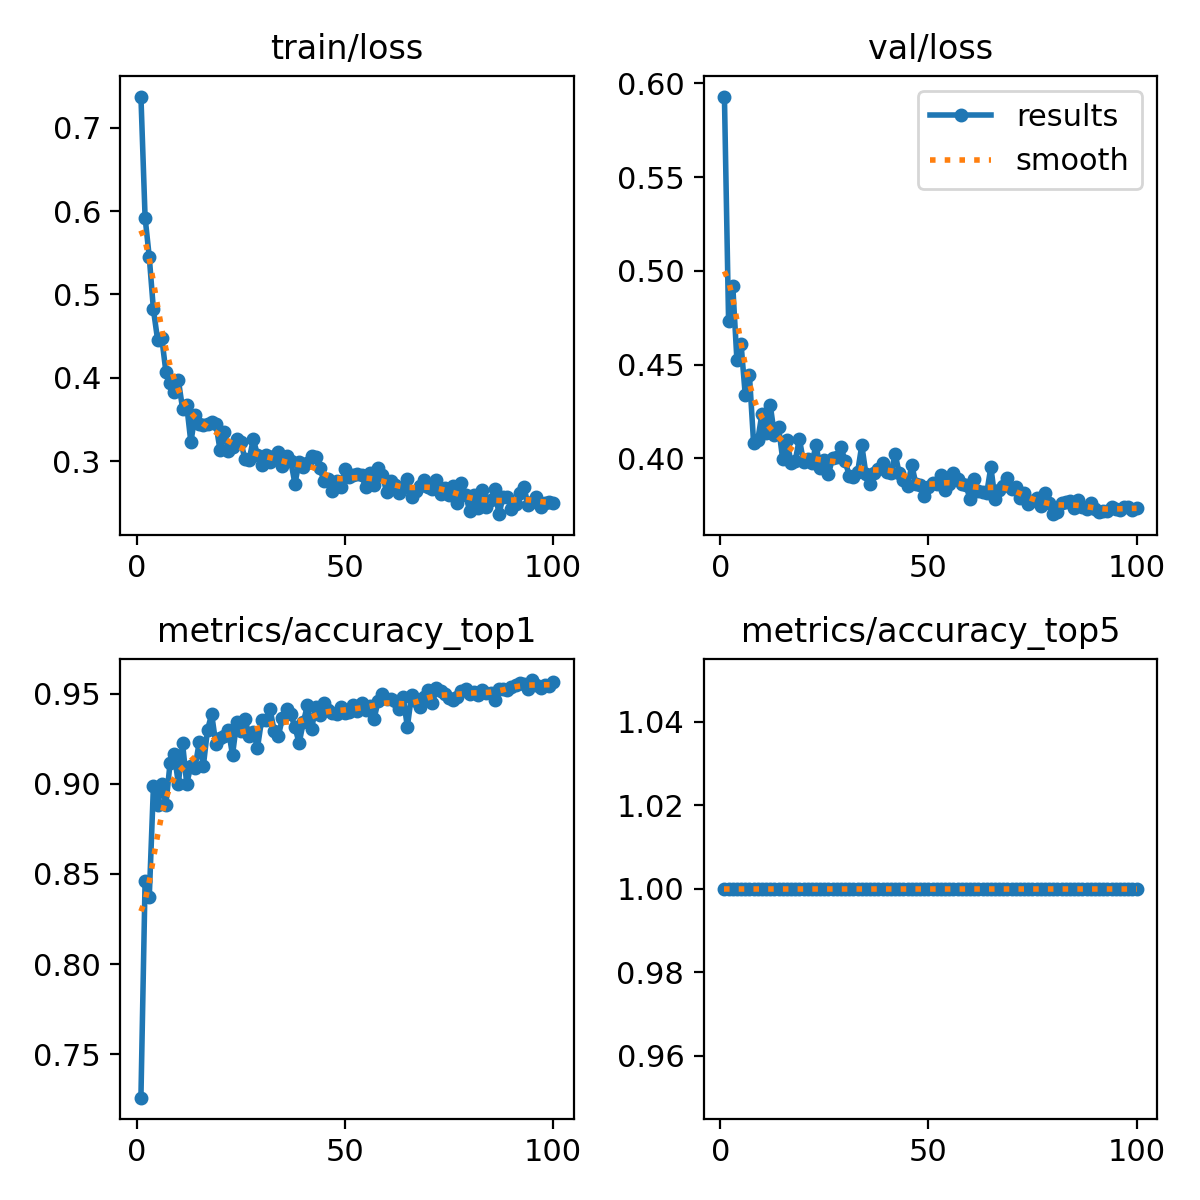

In [ ]:
path = "runs/classify/train7/"
Image(path+"results.png")

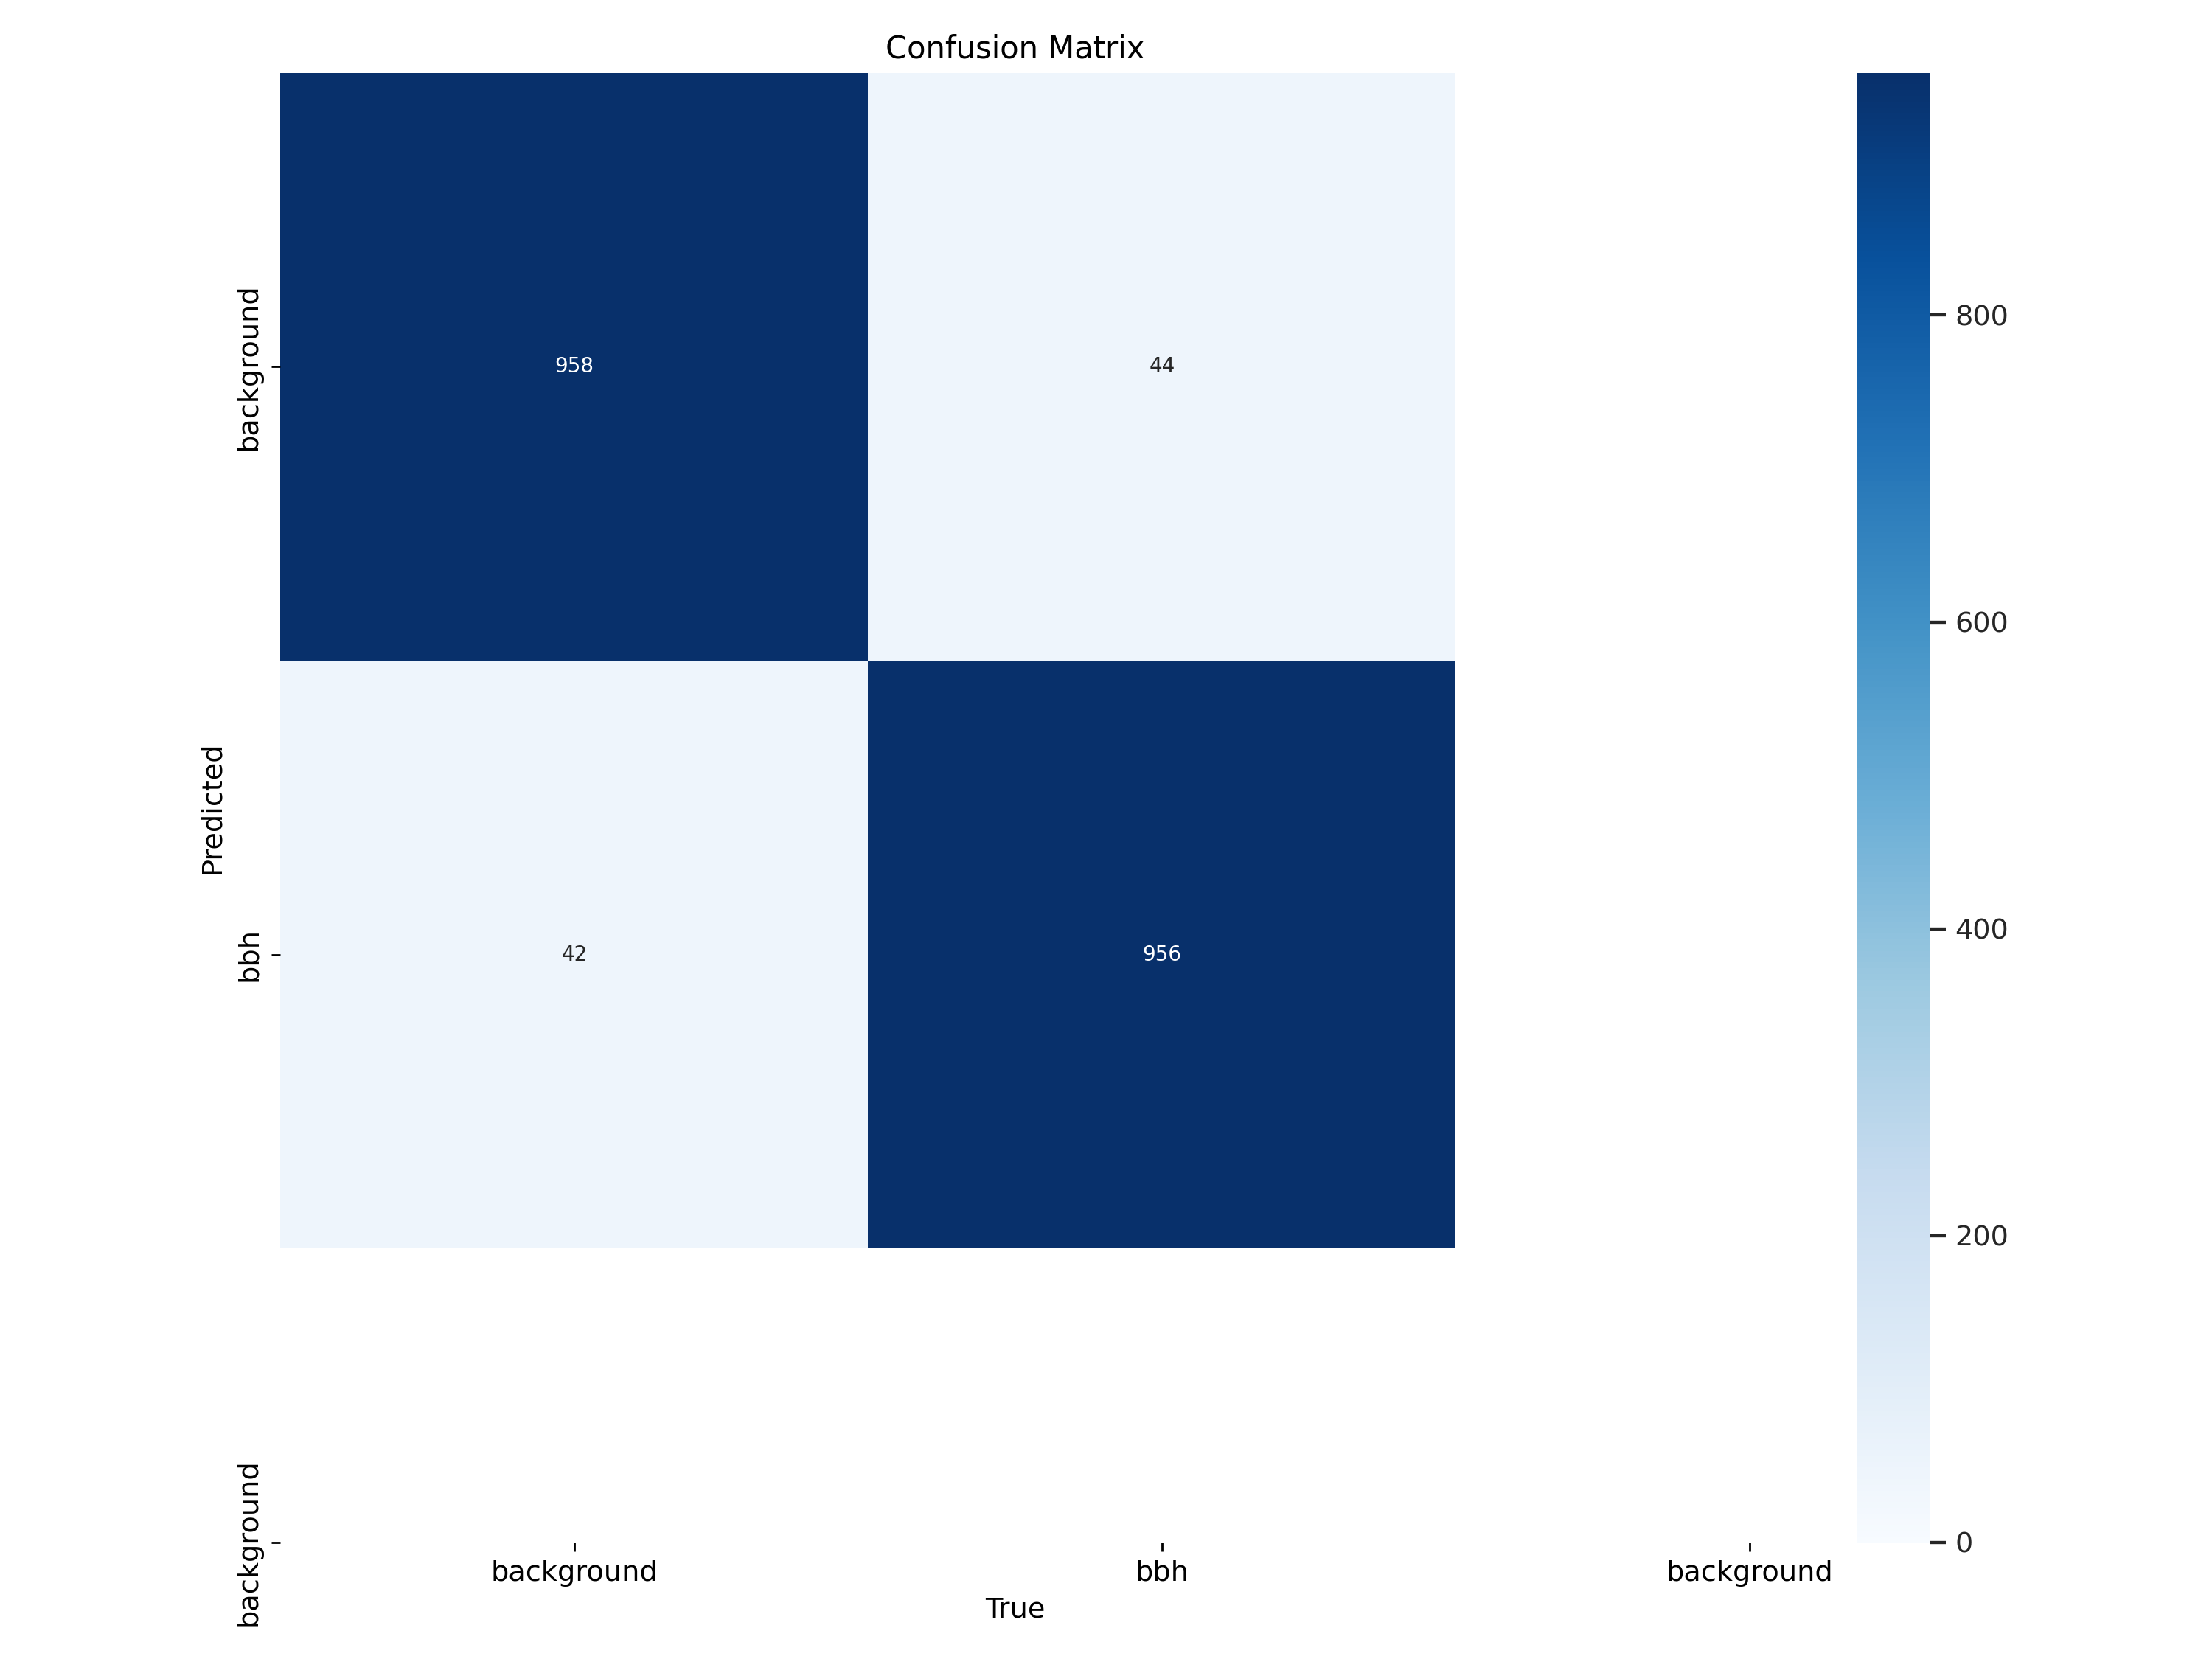

In [ ]:
Image(path+"confusion_matrix.png")

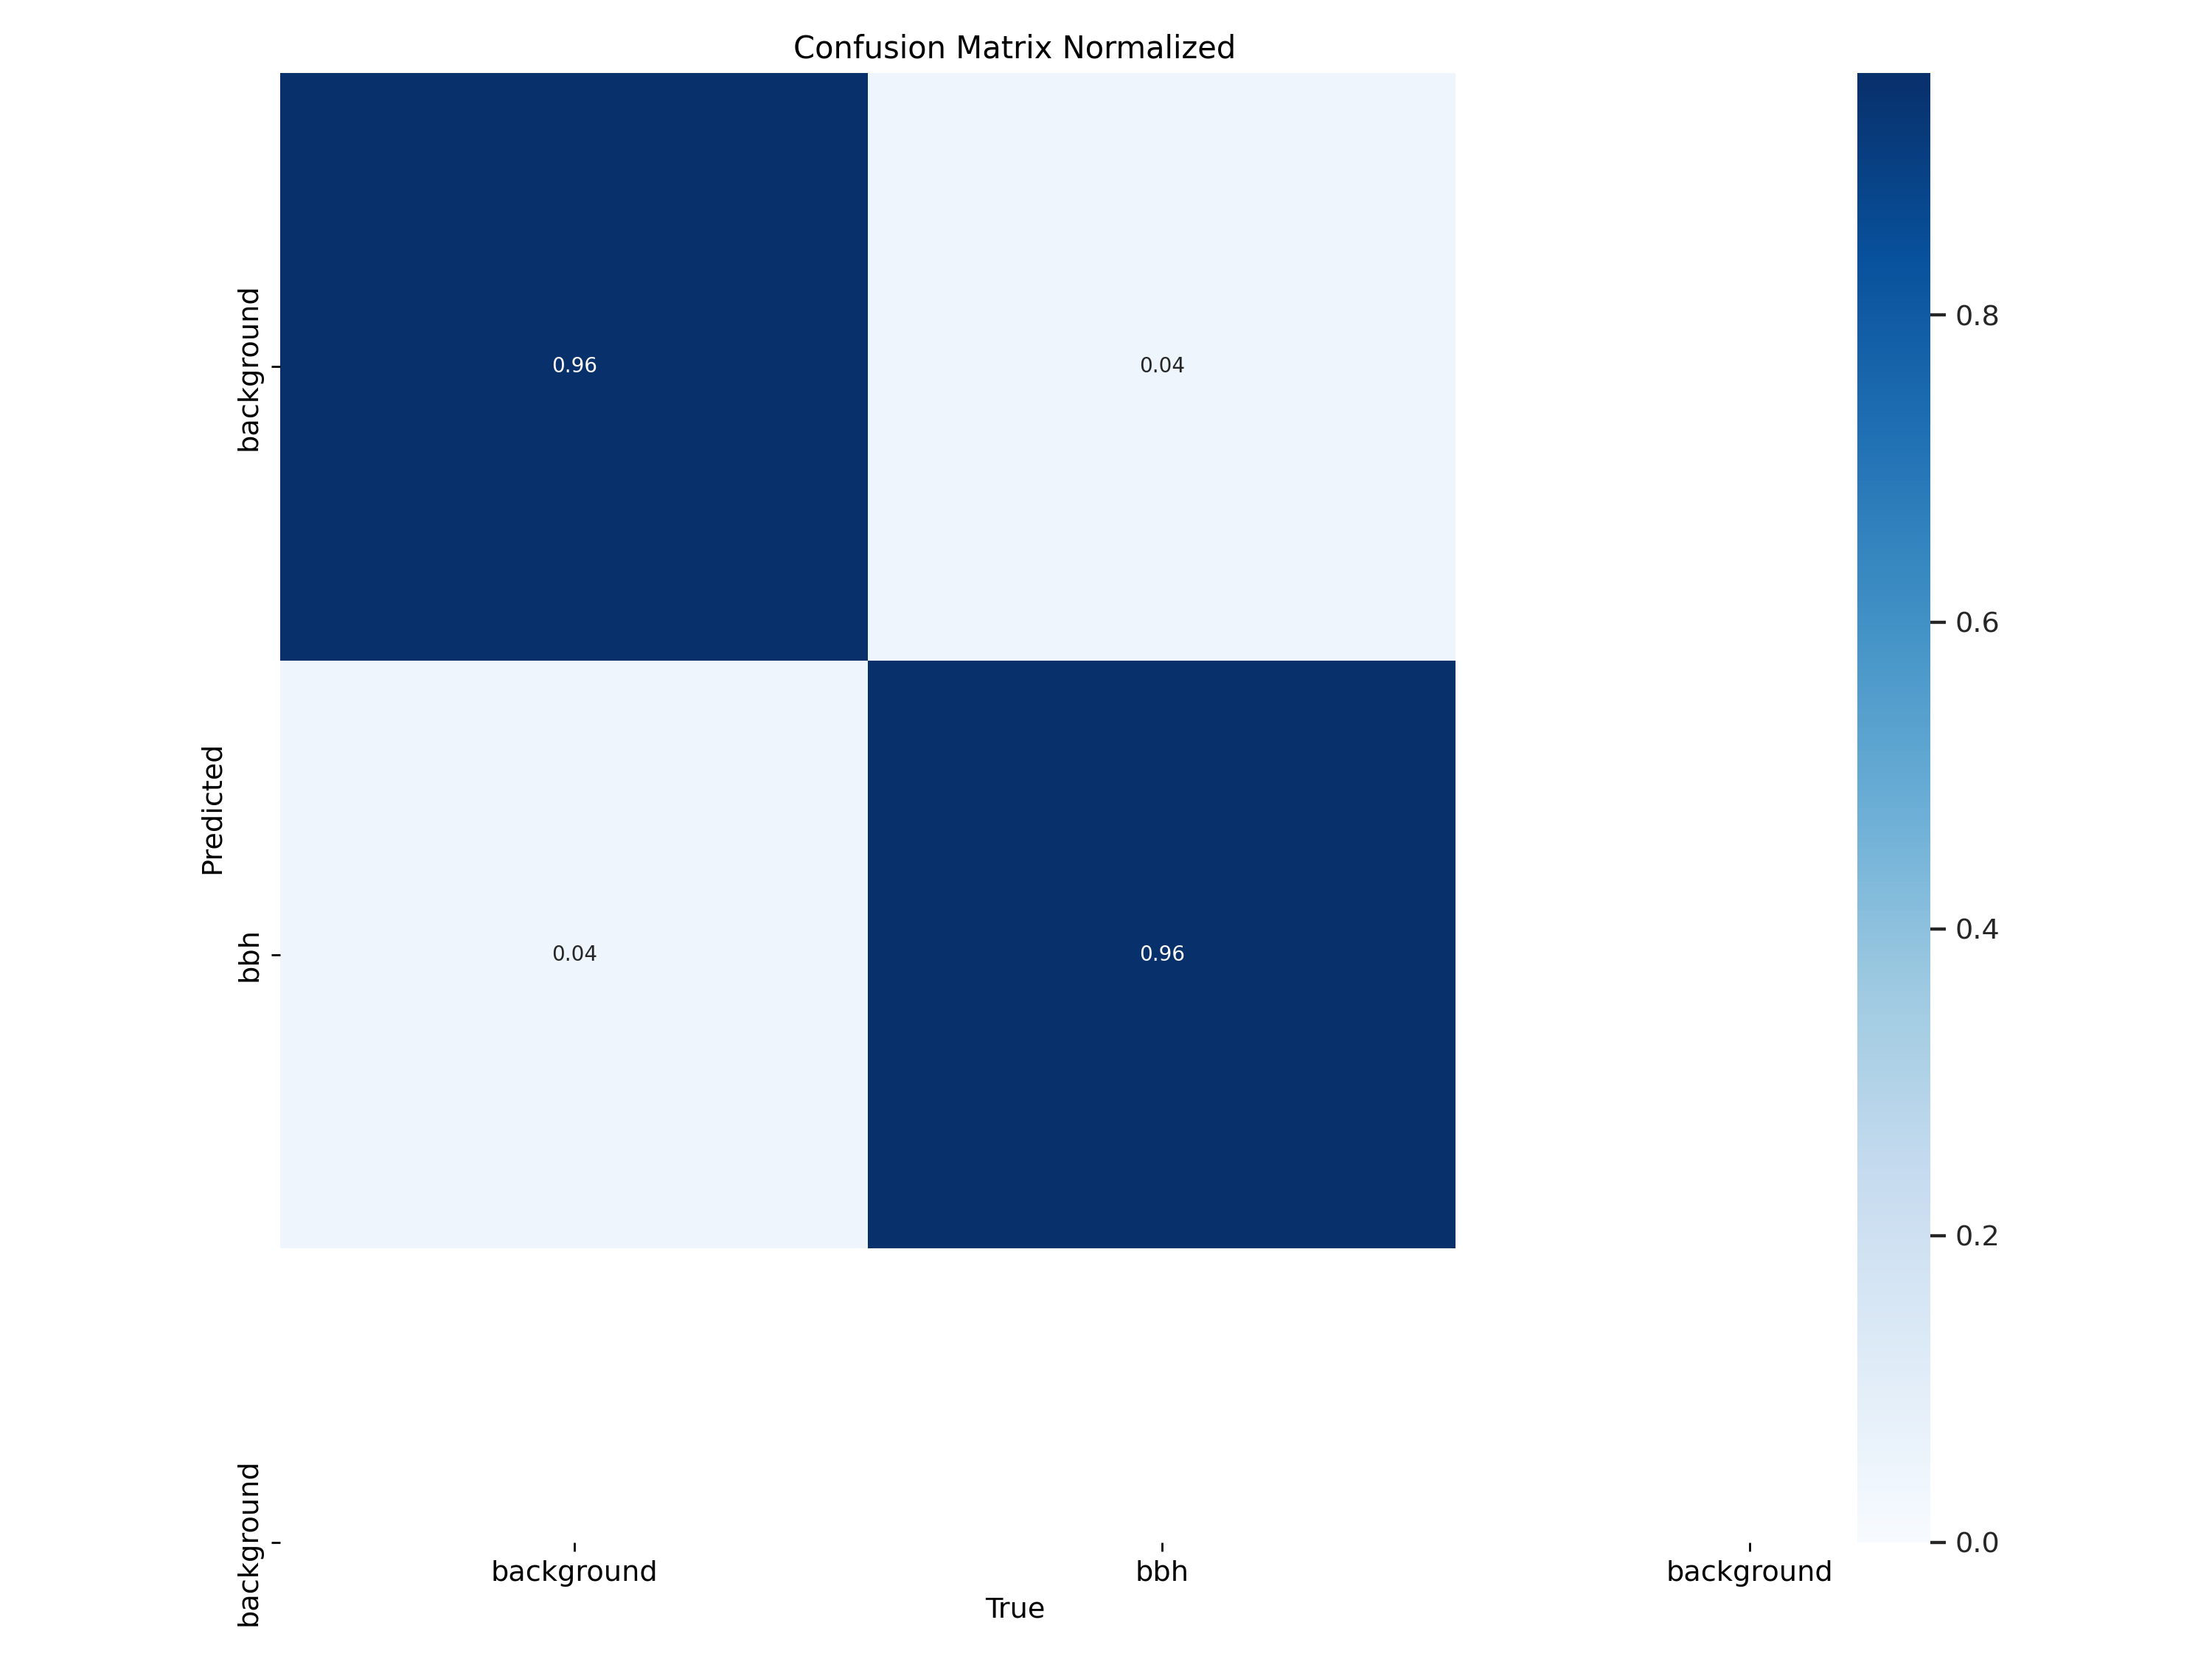

In [ ]:
Image(path+"confusion_matrix_normalized.png")

In [ ]:
df = pd.read_csv(path+'results.csv')
df

epoch       time  train/loss  metrics/accuracy_top1  \
0       1    39.2417     0.73732                 0.7260   
1       2    77.6299     0.59229                 0.8460   
2       3   116.3680     0.54515                 0.8370   
3       4   155.1940     0.48205                 0.8985   
4       5   194.0680     0.44586                 0.8880   
..    ...        ...         ...                    ...   
95     96  3621.4600     0.25742                 0.9545   
96     97  3657.6700     0.24558                 0.9530   
97     98  3694.3800     0.24941                 0.9550   
98     99  3730.8000     0.25175                 0.9540   
99    100  3767.2700     0.24951                 0.9565   

    metrics/accuracy_top5  val/loss    lr/pg0    lr/pg1    lr/pg2  
0                       1   0.59292  0.000236  0.000236  0.000236  
1                       1   0.47323  0.000469  0.000469  0.000469  
2                       1   0.49210  0.000698  0.000698  0.000698  
3                       1   0.45237  0.000693  0.000693  0.000693  
4                       1   0.46089  0.000686  0.000686  0.000686  
..                    ...       ...       ...       ...       ...  
95                      1   0.37227  0.000042  0.000042  0.000042  
96                      1   0.37402  0.000035  0.000035  0.000035  
97                      1   0.37397  0.000028  0.000028  0.000028  
98                      1   0.37264  0.000021  0.000021  0.000021  
99                      1   0.37362  0.000014  0.000014  0.000014  

[100 rows x 9 columns]

In [ ]:
# Load a model
model = YOLO("yolo11n-cls.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="anomaly_detection_data", epochs=10, imgsz=640)

Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=anomaly_detection_data, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sho

train: Scanning /home/fcerino/anomaly_detection_data/train... 2000 images, 0 cor
val: Scanning /home/fcerino/anomaly_detection_data/test... 2000 images, 0 corrup

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train8
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10         0G      0.644         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.768          1



      Epoch    GPU_mem       loss  Instances       Size


       2/10         0G     0.5001         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.822          1



      Epoch    GPU_mem       loss  Instances       Size


       3/10         0G     0.4262         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.895          1



      Epoch    GPU_mem       loss  Instances       Size


       4/10         0G     0.3814         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


       5/10         0G     0.3511         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.917          1



      Epoch    GPU_mem       loss  Instances       Size


       6/10         0G     0.3355         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:50<00:0

                   all      0.938          1



      Epoch    GPU_mem       loss  Instances       Size


       7/10         0G     0.3113         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:49<00:0

                   all      0.928          1



      Epoch    GPU_mem       loss  Instances       Size


       8/10         0G     0.2961         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:49<00:0

                   all      0.924          1



      Epoch    GPU_mem       loss  Instances       Size


       9/10         0G     0.2794         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:51<00:0

                   all      0.945          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G     0.2706         16        640: 100%|██████████| 125/12
               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:49<00:0

                   all      0.949          1



10 epochs completed in 0.454 hours.
Optimizer stripped from runs/classify/train8/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train8/weights/best.pt, 3.2MB

Validating runs/classify/train8/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /home/fcerino/anomaly_detection_data/train... found 2000 images in 2 classes ✅ 
val: None...
test: /home/fcerino/anomaly_detection_data/test... found 2000 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 63/63 [00:46<00:0


                   all      0.948          1
Speed: 0.0ms preprocess, 8.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train8


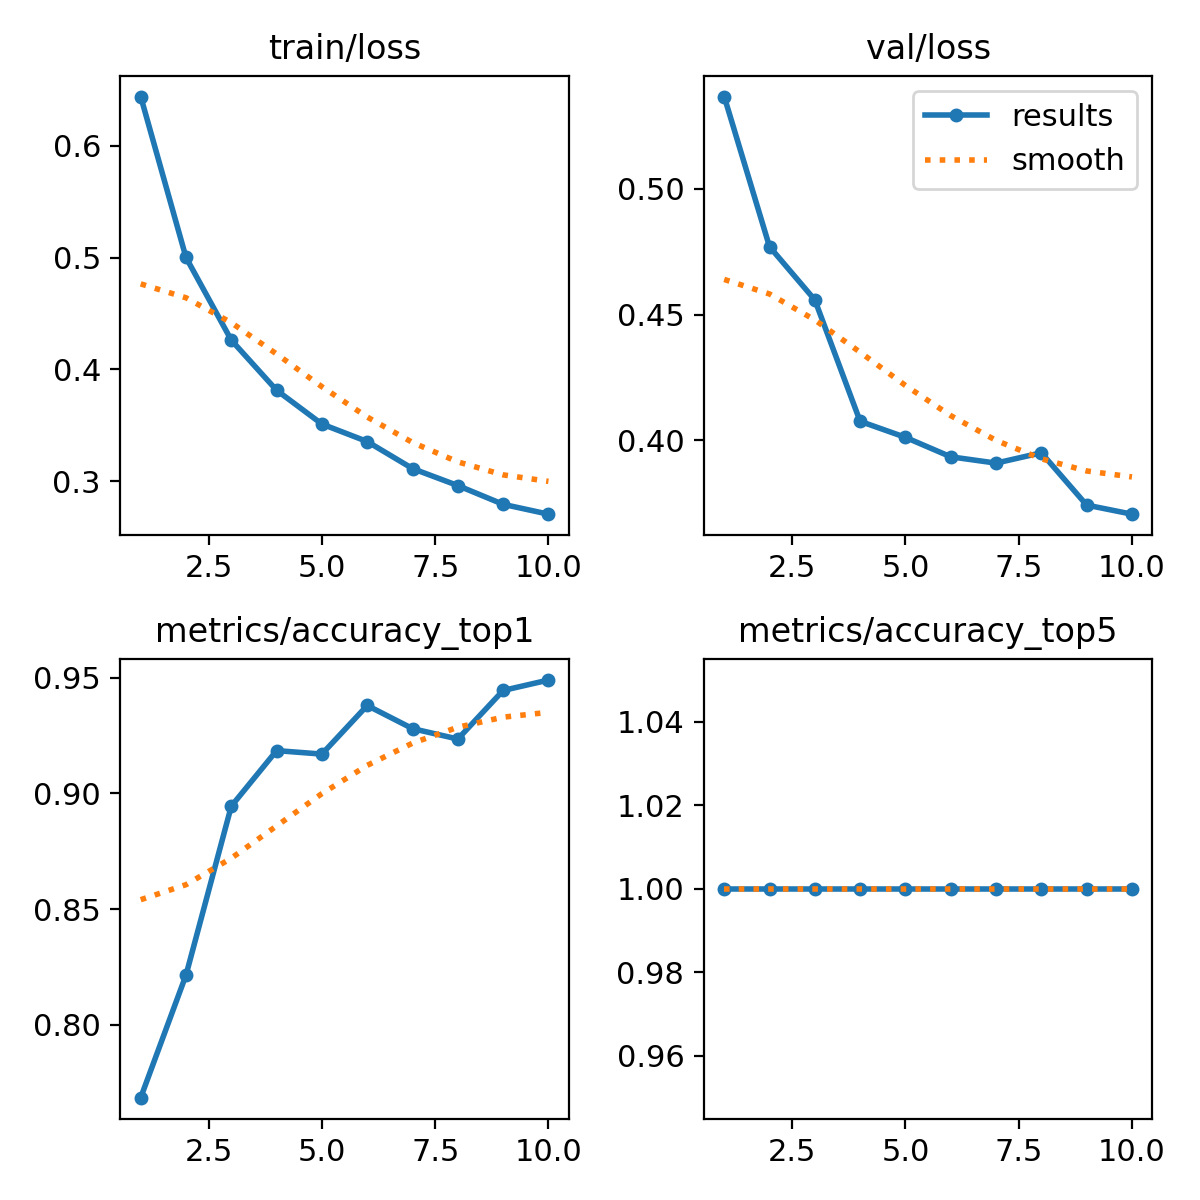

In [ ]:
path = "runs/classify/train8/"
Image(path+"results.png")

In [ ]:
df = pd.read_csv(path+'results.csv')
df

epoch      time  train/loss  metrics/accuracy_top1  metrics/accuracy_top5  \
0      1   166.124     0.64402                 0.7685                      1   
1      2   329.130     0.50010                 0.8215                      1   
2      3   492.155     0.42617                 0.8945                      1   
3      4   655.836     0.38136                 0.9185                      1   
4      5   818.889     0.35114                 0.9170                      1   
5      6   983.106     0.33549                 0.9380                      1   
6      7  1143.770     0.31132                 0.9280                      1   
7      8  1307.840     0.29612                 0.9235                      1   
8      9  1471.850     0.27936                 0.9445                      1   
9     10  1633.990     0.27055                 0.9490                      1   

   val/loss    lr/pg0    lr/pg1    lr/pg2  
0   0.53677  0.000236  0.000236  0.000236  
1   0.47701  0.000427  0.000427  0.000427  
2   0.45584  0.000571  0.000571  0.000571  
3   0.40751  0.000502  0.000502  0.000502  
4   0.40113  0.000431  0.000431  0.000431  
5   0.39338  0.000361  0.000361  0.000361  
6   0.39087  0.000290  0.000290  0.000290  
7   0.39498  0.000219  0.000219  0.000219  
8   0.37417  0.000149  0.000149  0.000149  
9   0.37055  0.000078  0.000078  0.000078

In [ ]:
# use 5k samples now

model = YOLO("yolo11n-cls.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="anomaly_detection_data", epochs=10, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.32 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=anomaly_detection_data, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train11, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

train: Scanning /home/fcerino/anomaly_detection_data/train... 10000 images, 0 co
val: Scanning /home/fcerino/anomaly_detection_data/test... 10000 images, 0 corru

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train11
Starting training for 10 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/10         0G     0.5179         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:48<00

                   all      0.919          1



      Epoch    GPU_mem       loss  Instances       Size


       2/10         0G     0.3721         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:09<00

                   all      0.927          1



      Epoch    GPU_mem       loss  Instances       Size


       3/10         0G     0.3349         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.936          1



      Epoch    GPU_mem       loss  Instances       Size


       4/10         0G     0.3178         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:02<00

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


       5/10         0G     0.2906         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:02<00

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


       6/10         0G     0.2757         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:02<00

                   all      0.939          1



      Epoch    GPU_mem       loss  Instances       Size


       7/10         0G     0.2683         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:02<00

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


       8/10         0G     0.2471         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:07<00

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


       9/10         0G     0.2375         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [03:58<00

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      10/10         0G     0.2292         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [03:56<00

                   all      0.952          1



10 epochs completed in 2.265 hours.
Optimizer stripped from runs/classify/train11/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train11/weights/best.pt, 3.2MB

Validating runs/classify/train11/weights/best.pt...
Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
YOLO11n-cls summary (fused): 112 layers, 1,528,586 parameters, 0 gradients, 3.2 GFLOPs
WARNING ⚠️ Dataset 'split=val' not found, using 'split=test' instead.
train: /home/fcerino/anomaly_detection_data/train... found 10000 images in 2 classes ✅ 
val: None...
test: /home/fcerino/anomaly_detection_data/test... found 10000 images in 2 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [03:42<00


                   all      0.952          1
Speed: 0.0ms preprocess, 8.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train11


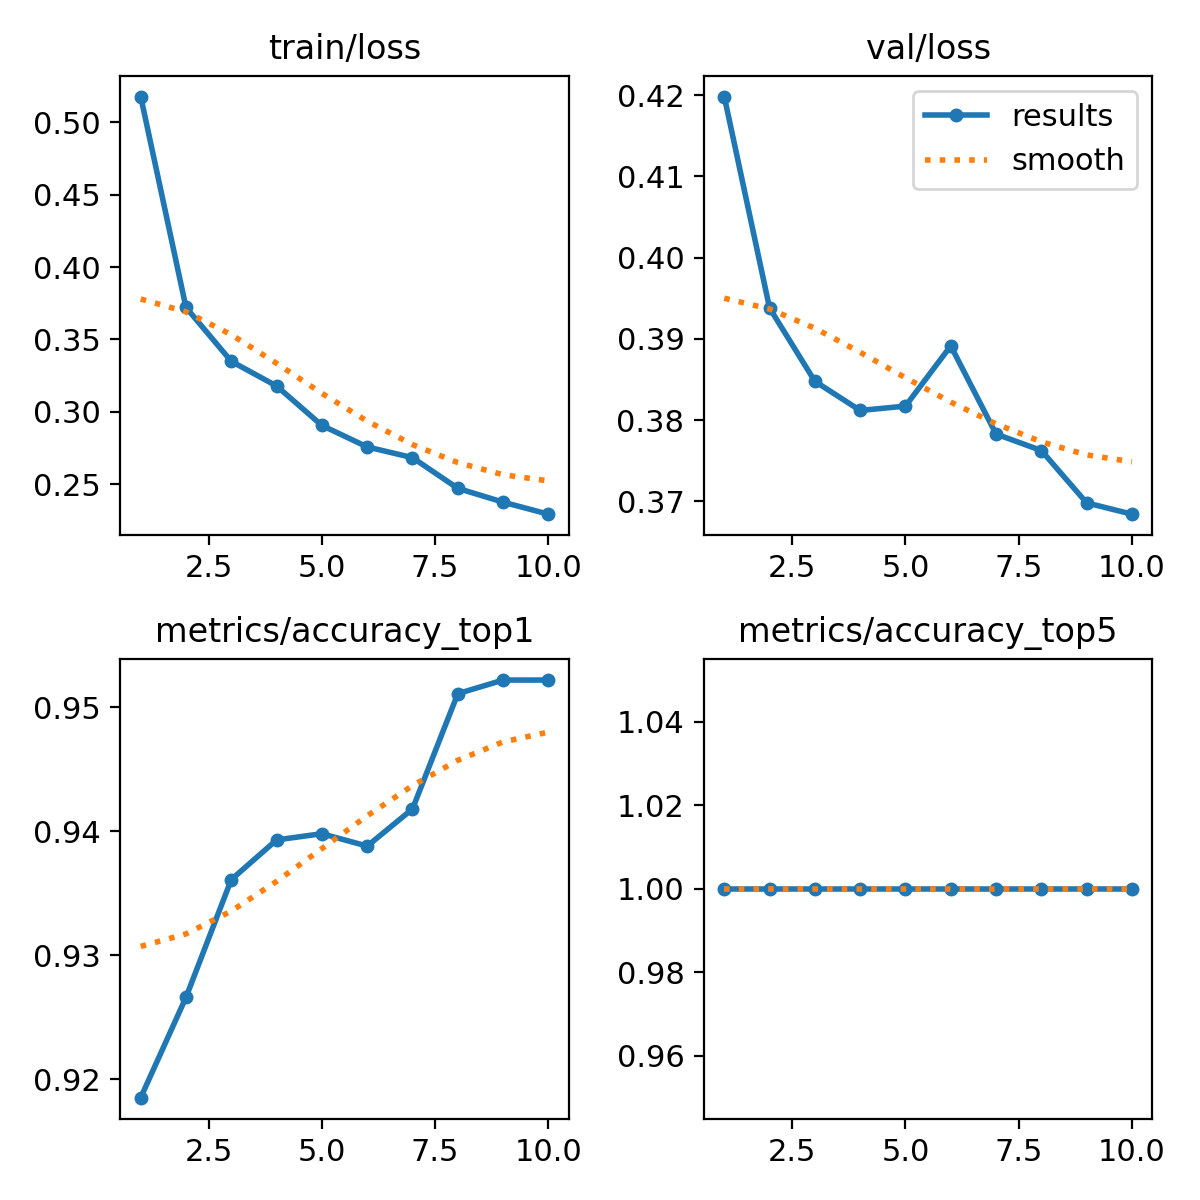

In [ ]:
path = "runs/classify/train11/"
Image(path+"results.png")

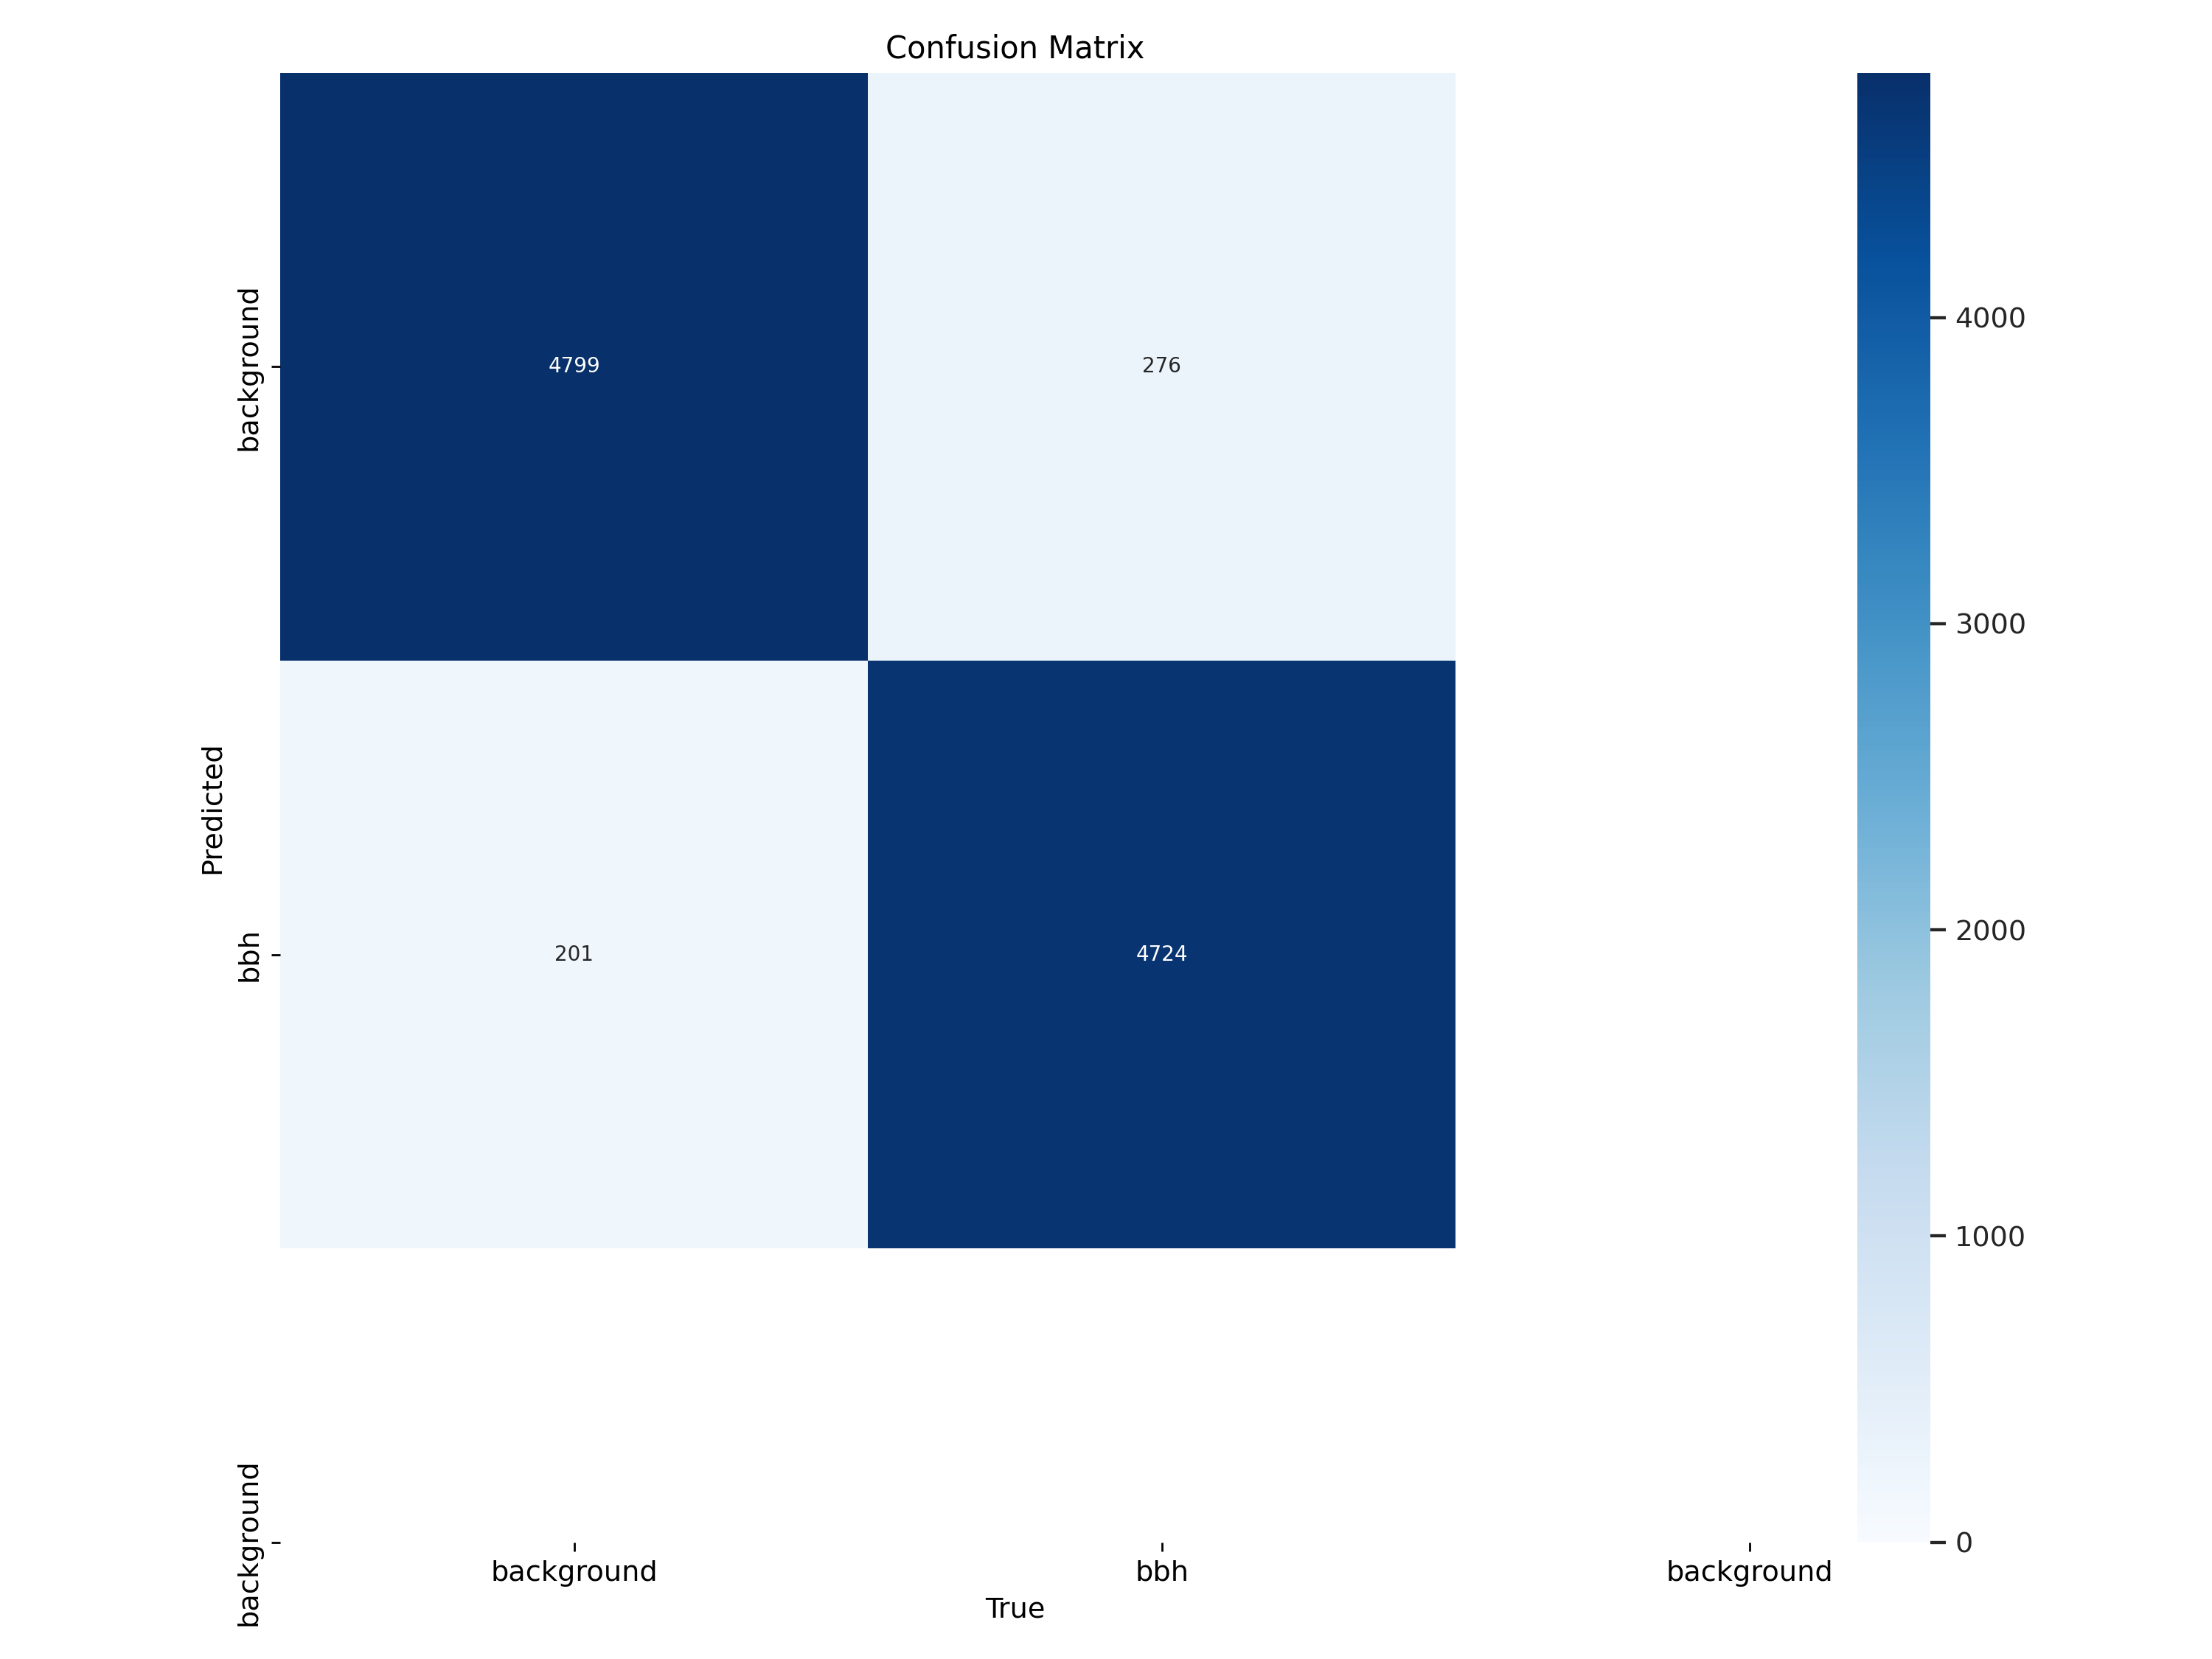

In [ ]:
Image(path+"confusion_matrix.png")

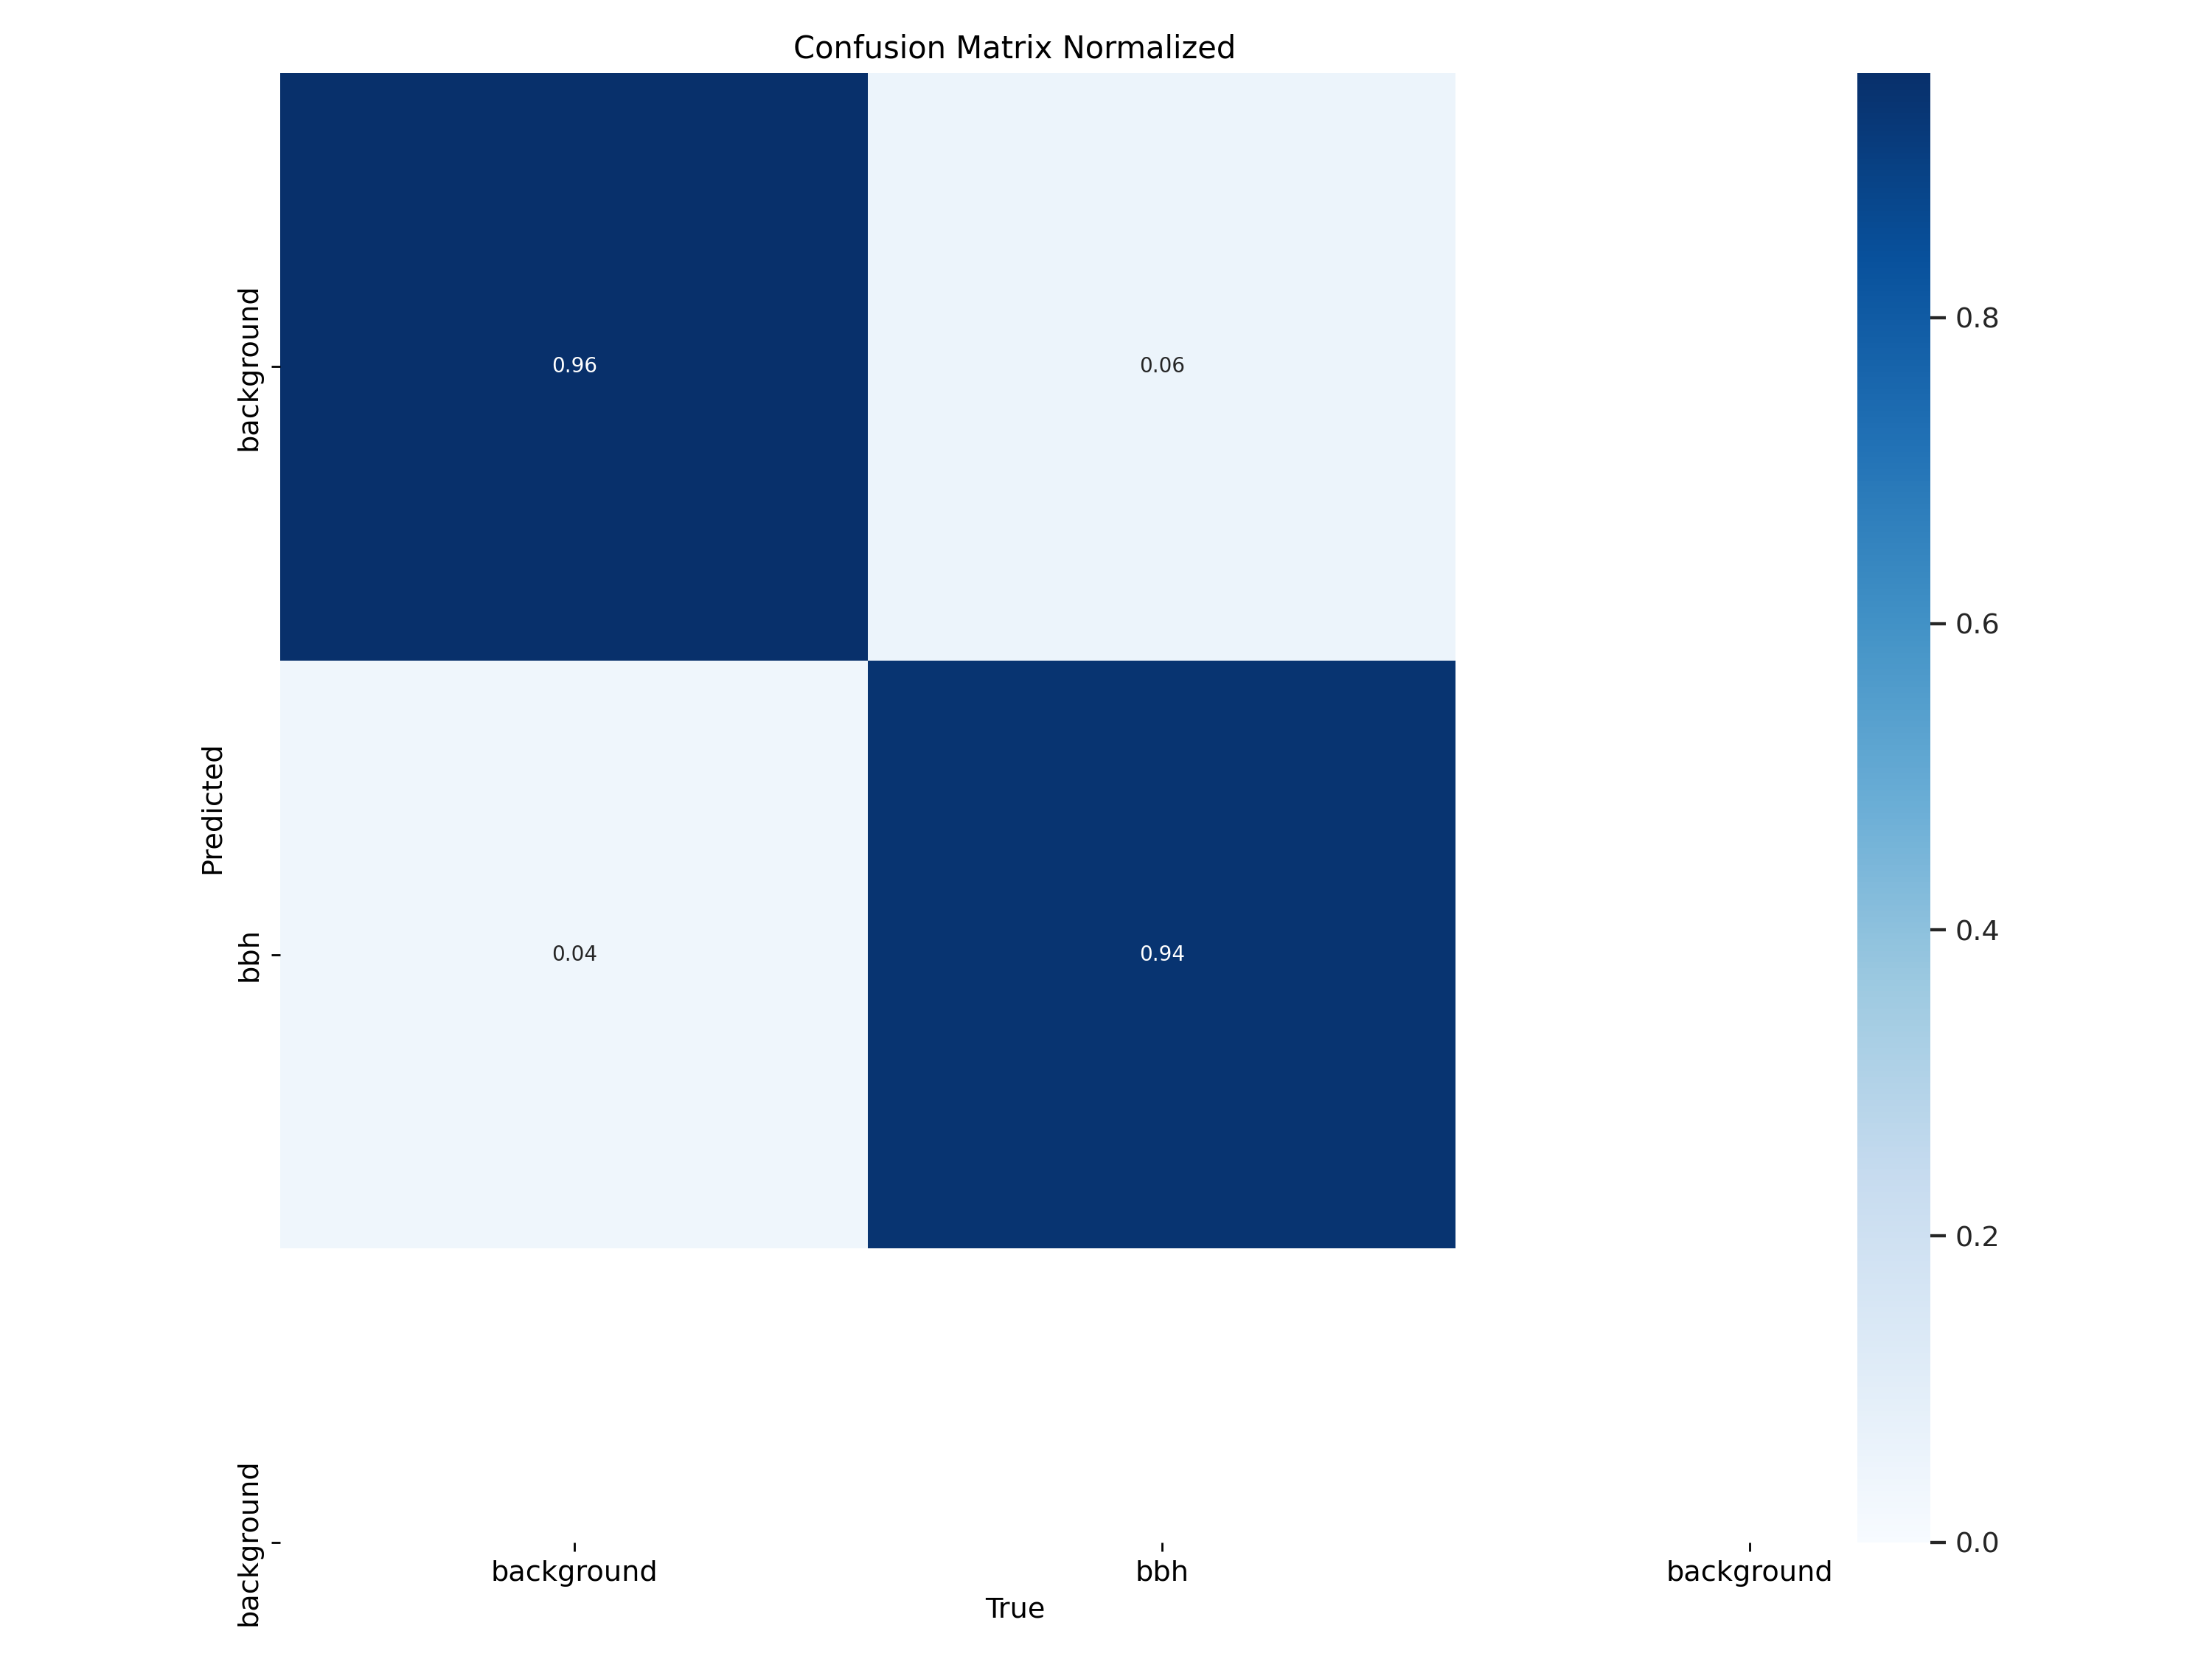

In [ ]:
Image(path+"confusion_matrix_normalized.png")

In [ ]:
df = pd.read_csv(path+'results.csv')
df

epoch     time  train/loss  metrics/accuracy_top1  metrics/accuracy_top5  \
0      1   901.17     0.51789                 0.9185                      1   
1      2  1809.20     0.37210                 0.9266                      1   
2      3  2610.68     0.33488                 0.9361                      1   
3      4  3403.36     0.31781                 0.9393                      1   
4      5  4194.71     0.29057                 0.9398                      1   
5      6  4991.22     0.27571                 0.9388                      1   
6      7  5784.23     0.26830                 0.9418                      1   
7      8  6586.32     0.24708                 0.9511                      1   
8      9  7370.98     0.23753                 0.9522                      1   
9     10  8153.32     0.22923                 0.9522                      1   

   val/loss    lr/pg0    lr/pg1    lr/pg2  
0   0.41982  0.000238  0.000238  0.000238  
1   0.39380  0.000429  0.000429  0.000429  
2   0.38478  0.000572  0.000572  0.000572  
3   0.38119  0.000502  0.000502  0.000502  
4   0.38173  0.000431  0.000431  0.000431  
5   0.38914  0.000361  0.000361  0.000361  
6   0.37829  0.000290  0.000290  0.000290  
7   0.37626  0.000219  0.000219  0.000219  
8   0.36982  0.000149  0.000149  0.000149  
9   0.36843  0.000078  0.000078  0.000078

In [ ]:
# use 5k samples now

model = YOLO("yolo11n-cls.pt")  # load a pretrained model (recommended for training)

# Train the model
results = model.train(data="anomaly_detection_data", epochs=30, imgsz=640)

New https://pypi.org/project/ultralytics/8.3.32 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.31 🚀 Python-3.12.7 torch-2.5.1+cu124 CPU (AMD Ryzen Threadripper PRO 3975WX 32-Cores)
engine/trainer: task=classify, mode=train, model=yolo11n-cls.pt, data=anomaly_detection_data, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train12, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, 

train: Scanning /home/fcerino/anomaly_detection_data/train... 10000 images, 0 co
val: Scanning /home/fcerino/anomaly_detection_data/test... 10000 images, 0 corru

optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 39 weight(decay=0.0), 40 weight(decay=0.0005), 40 bias(decay=0.0)


TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/classify/train12
Starting training for 30 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/30         0G     0.5099         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [05:12<00

                   all      0.914          1



      Epoch    GPU_mem       loss  Instances       Size


       2/30         0G     0.3756         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [05:10<00

                   all      0.906          1



      Epoch    GPU_mem       loss  Instances       Size


       3/30         0G     0.3446         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [05:12<00

                   all      0.935          1



      Epoch    GPU_mem       loss  Instances       Size


       4/30         0G     0.3261         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:01<00

                   all      0.931          1



      Epoch    GPU_mem       loss  Instances       Size


       5/30         0G     0.3005         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [03:58<00

                   all      0.932          1



      Epoch    GPU_mem       loss  Instances       Size


       6/30         0G     0.2958         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:01<00

                   all       0.94          1



      Epoch    GPU_mem       loss  Instances       Size


       7/30         0G     0.2824         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:01<00

                   all      0.944          1



      Epoch    GPU_mem       loss  Instances       Size


       8/30         0G     0.2715         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:01<00

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


       9/30         0G     0.2601         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.941          1



      Epoch    GPU_mem       loss  Instances       Size


      10/30         0G     0.2593         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [03:59<00

                   all      0.942          1



      Epoch    GPU_mem       loss  Instances       Size


      11/30         0G     0.2561         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      12/30         0G     0.2526         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:08<00

                   all      0.948          1



      Epoch    GPU_mem       loss  Instances       Size


      13/30         0G     0.2477         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      14/30         0G     0.2384         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:05<00

                   all      0.947          1



      Epoch    GPU_mem       loss  Instances       Size


      15/30         0G     0.2347         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:09<00

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      16/30         0G     0.2293         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.952          1



      Epoch    GPU_mem       loss  Instances       Size


      17/30         0G     0.2293         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.956          1



      Epoch    GPU_mem       loss  Instances       Size


      18/30         0G     0.2285         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.951          1



      Epoch    GPU_mem       loss  Instances       Size


      19/30         0G     0.2167         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:03<00

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      20/30         0G     0.2197         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc: 100%|██████████| 313/313 [04:00<00

                   all      0.954          1



      Epoch    GPU_mem       loss  Instances       Size


      21/30         0G     0.2163         16        640: 100%|██████████| 625/62
               classes   top1_acc   top5_acc:  67%|██████▋   | 211/313 [02:56<01

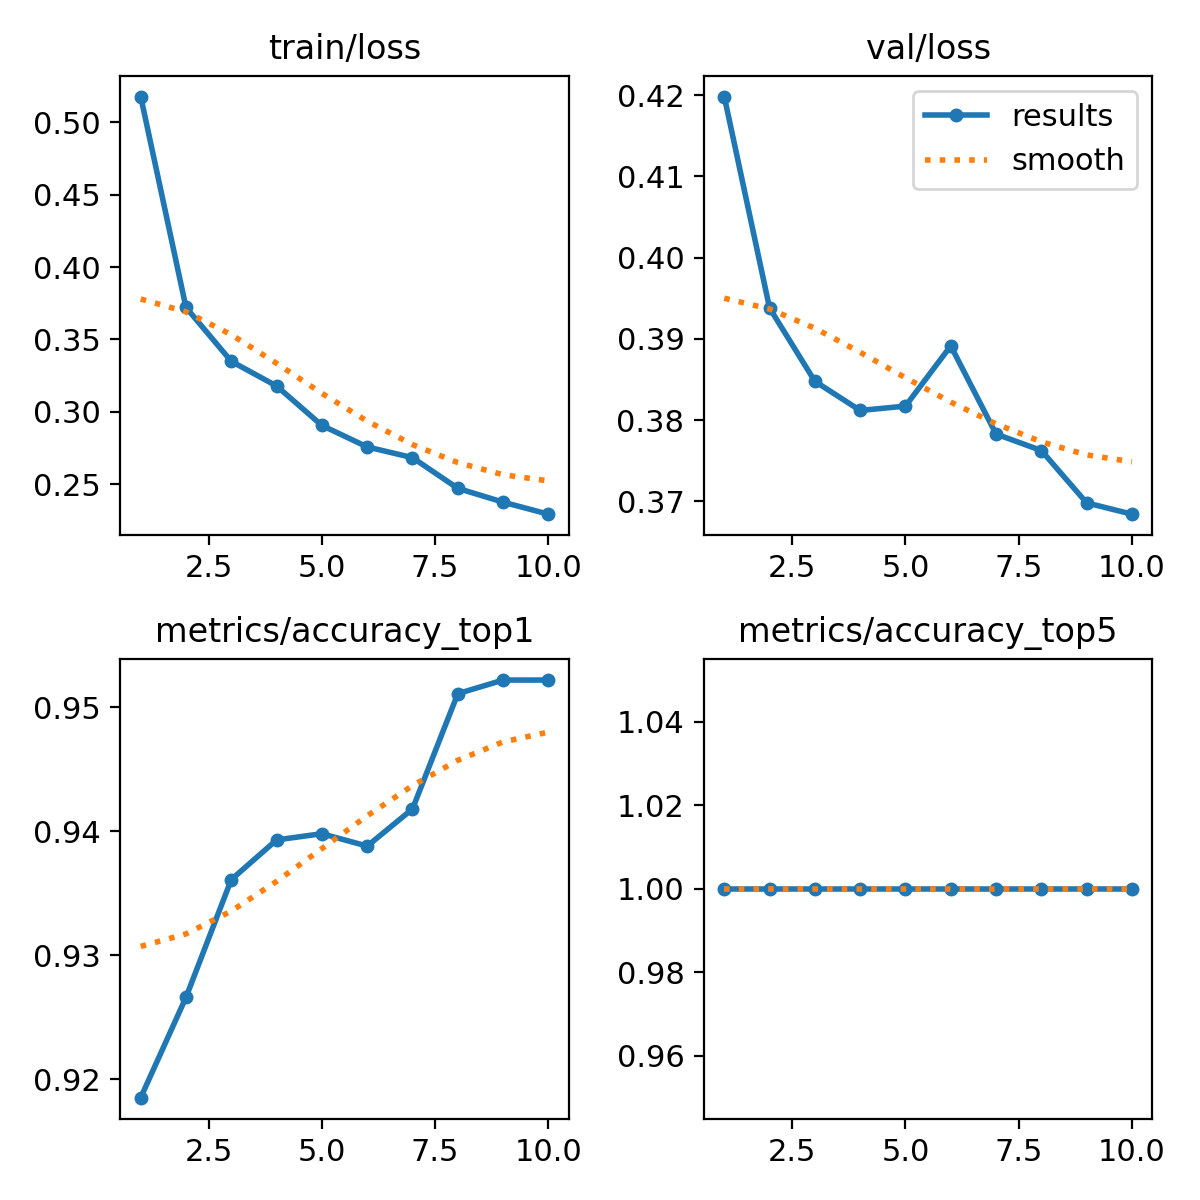

In [ ]:
path = "runs/classify/train11/"
Image(path+"results.png")

# **Modelos no supervisados**


## Entrenando un Transformer


El modelo incluye los siguientes componentes:

Transformer Encoder: incluye conexiones residuales, normalización de capas, dropout y capas de atención. Las capas de proyección se implementan usando una convolución 1D. Estas capas se pueden apilar varias veces.

Dense Decoder: Después del Encoder del transformer, se utiliza el Dense Decoder. Aplica varias capas densas con conexiones residuales, dropout y normalización de capas, y luego reforma la salida a la forma de entrada original.

La capa final del modelo es una capa densa que genera un tensor de la misma forma que la entrada.

In [ ]:
# Create train and test datasets
x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 200, 2) (20000, 200, 2)
y train/test shapes: (80000, 200, 2) (20000, 200, 2)


In [ ]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

# hacer matriz de confusion

Epoch 1/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 632s 311ms/step - loss: 1.2096 - val_loss: 0.6284
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 668s 304ms/step - loss: 0.6107 - val_loss: 0.5213
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 607s 304ms/step - loss: 0.5148 - val_loss: 0.4276
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 605s 303ms/step - loss: 0.4181 - val_loss: 0.2996
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 620s 302ms/step - loss: 0.3046 - val_loss: 0.2255
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 625s 303ms/step - loss: 0.2329 - val_loss: 0.1752
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 617s 301ms/step - loss: 0.1901 - val_loss: 0.1466
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 626s 303ms/step - loss: 0.1636 - val_loss: 0.1294
Epoch 9/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 605s 303ms/step - loss: 0.1470 - val_loss: 0.1160
Epoch 10/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 621s 302ms/step - loss: 0.1357 - val_loss: 0.1089
Epoch 11/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 620s 301ms/step - loss: 0.1243 - val

In [ ]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')

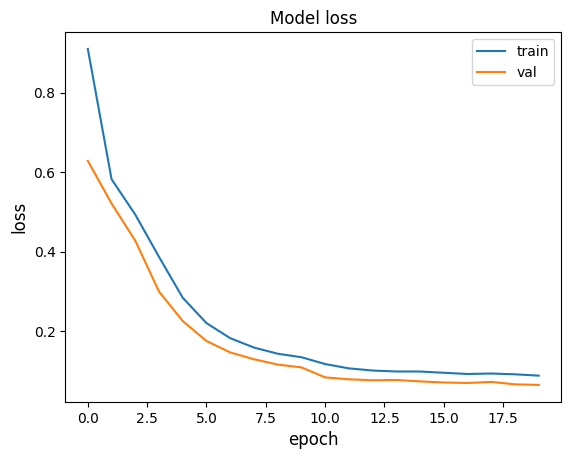

In [ ]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 104ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 349s 112ms/step


In [ ]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

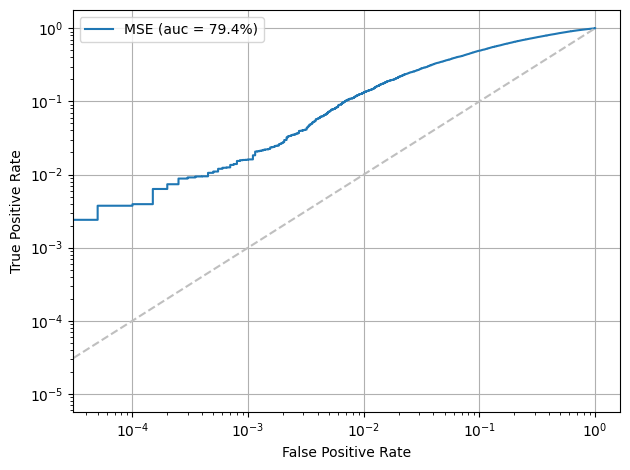

In [ ]:
make_plot_roc_curves(background_test, signal_test)

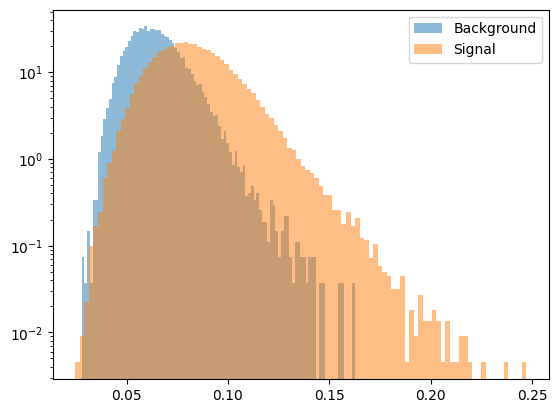

In [ ]:
plt.hist(background_test, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

In [ ]:
def make_plot_roc_curves(qcd, bsm):
    # True labels and predicted values
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    # ROC Curve
    fpr_loss, tpr_loss, thresholds = roc_curve(true_val, pred_val)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Find the best threshold by maximizing Youden's J statistic (TPR - FPR)
    j_scores = tpr_loss - fpr_loss
    best_threshold_index = np.argmax(j_scores)
    best_threshold = thresholds[best_threshold_index]

    # Plot ROC Curve
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (AUC = {auc_loss*100:.1f}%)', linewidth=1.5)
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.scatter(fpr_loss[best_threshold_index], tpr_loss[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.title('ROC Curve')

    # Apply best threshold to convert predictions to binary
    pred_binary = (pred_val >= best_threshold).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(true_val, pred_binary)

    # Plot Confusion Matrix
    plt.subplot(1, 2, 2)
    ConfusionMatrixDisplay(cm, display_labels=["QCD (0)", "BSM (1)"]).plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title(f'Confusion Matrix (Best Threshold = {best_threshold:.2f})')
    plt.tight_layout()
    plt.show()

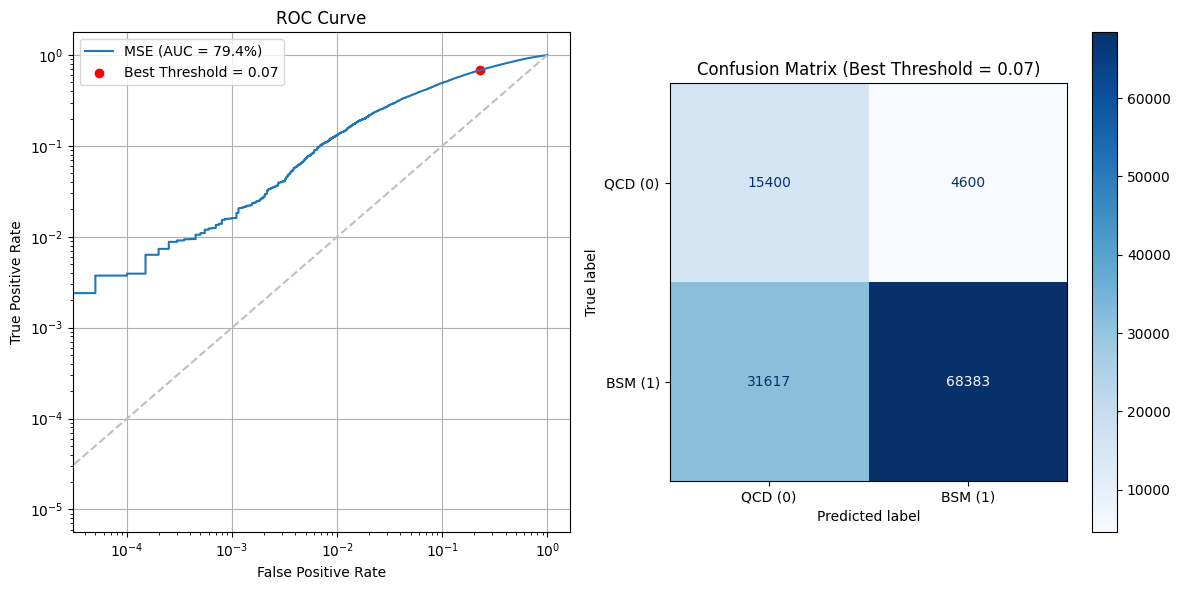

In [ ]:
make_plot_roc_curves(background_test, signal_test)

In [ ]:
#pretrained_model = Model()
#pretrained_model.load()

## Check its architecture
#pretrained_model.ae.summary()

## Entrenando un Autoencoder simple


Con un autoencoder reducimos la dimensionalidad de los datos de entrada a un espacio latente de forma que se minimice el error de reconstruccion al espacio inicial.

compuesto por un encoder y un decoder:

- encoder: $x^n$->$x^m$ con $m<n$
- decoder: $x^m$->$x^n$
- decoder(encoder($input$)) $\approx$ $input$

Se evita $m$ = $n$ para no aprender la funcion identidad.

Se lleva los datos a una dimension menor y se obtiene la informacion más relevante para que la reconstrucción con el decoder sea precisa.









In [ ]:
class SimpleAutoencoder:
    def __init__(self):
        super().__init__()

    def build_model(self, input_shape, encoding_dim):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = layers.Flatten()(inputs)
        x = layers.Dense(encoding_dim, activation="relu")(x)

        # Decoder
        x = layers.Dense(np.prod(input_shape), activation="sigmoid")(x)
        outputs = layers.Reshape(input_shape)(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        reconstruction_error = np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1, 2))
        return reconstruction_error

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'simple_autoencoder.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'simple_autoencoder.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
encoding_dim = 64                 # Latent space dimension

# Build and compile the simple autoencoder
simple_autoencoder = SimpleAutoencoder()
simple_autoencoder.build_model(input_shape=input_shape, encoding_dim=encoding_dim)

# Train the autoencoder
history = simple_autoencoder.fit(
    x_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 1.1006 - val_loss: 0.9906
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9839 - val_loss: 0.9571
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.9466 - val_loss: 0.9244
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.9185 - val_loss: 0.9092
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.9050 - val_loss: 0.9009
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.8973 - val_loss: 0.8956
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8920 - val_loss: 0.8916
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.8881 - val_loss: 0.8885
Epoch 9/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.8848 - val_loss: 0.8858
Epoch 10/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.8818 - val_loss: 0.8833
Epoch 11/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.8792 - val_loss: 0.8810
Epoch 12/100
2000/

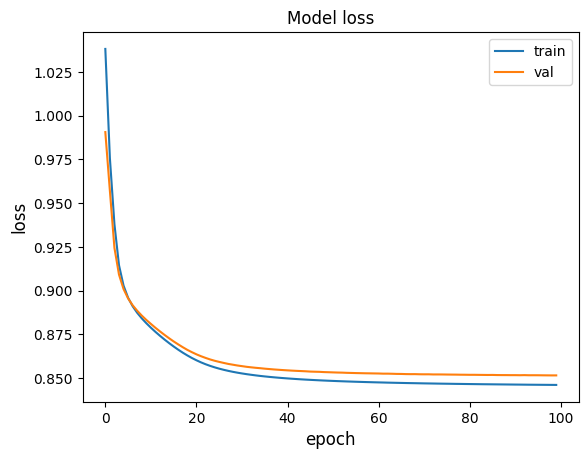

In [ ]:
# train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

In [ ]:
# evaluate on test background and signal samples
background_test_simple = simple_autoencoder.predict(x_test)
signal_test_simple = simple_autoencoder.predict(bbh)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


In [ ]:
bbh.shape

(100000, 200, 2)

In [ ]:
background_test_simple.shape

(20000,)

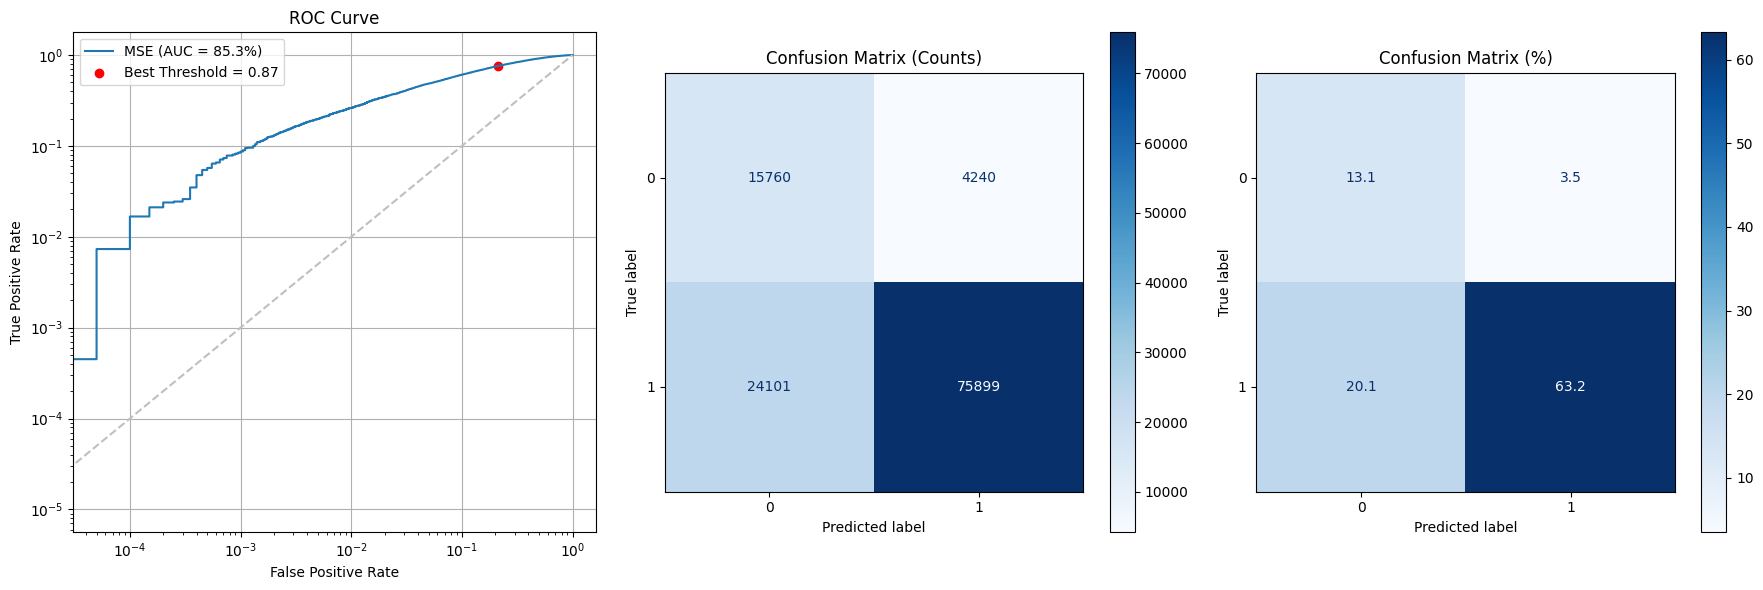

In [ ]:
def make_plot_roc_curves(qcd, bsm):
    # True labels and predicted values
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    # ROC Curve
    fpr_loss, tpr_loss, thresholds = roc_curve(true_val, pred_val)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Find the best threshold by maximizing Youden's J statistic (TPR - FPR)
    j_scores = tpr_loss - fpr_loss
    best_threshold_index = np.argmax(j_scores)
    best_threshold = thresholds[best_threshold_index]

    # Apply best threshold to convert predictions to binary
    pred_binary = (pred_val >= best_threshold).astype(int)

    # Confusion Matrix (Counts and Percentages)
    cm = confusion_matrix(true_val, pred_binary)
    cm_percent = cm.astype('float') / cm.sum() * 100  # Normalize to percentages

    # Plot ROC Curve
    plt.figure(figsize=(18, 6))

    # ROC Curve plot
    plt.subplot(1, 3, 1)
    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (AUC = {auc_loss*100:.1f}%)', linewidth=1.5)
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.scatter(fpr_loss[best_threshold_index], tpr_loss[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.title('ROC Curve')

    # Confusion Matrix (Counts)
    plt.subplot(1, 3, 2)
    ConfusionMatrixDisplay(cm, display_labels=["0", "1"]).plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title(f'Confusion Matrix (Counts)')

    # Confusion Matrix (Percentages)
    plt.subplot(1, 3, 3)
    ConfusionMatrixDisplay(cm_percent, display_labels=["0", "1"]).plot(cmap="Blues", values_format=".1f", ax=plt.gca())
    plt.title(f'Confusion Matrix (%)')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

make_plot_roc_curves(background_test_simple, signal_test_simple)

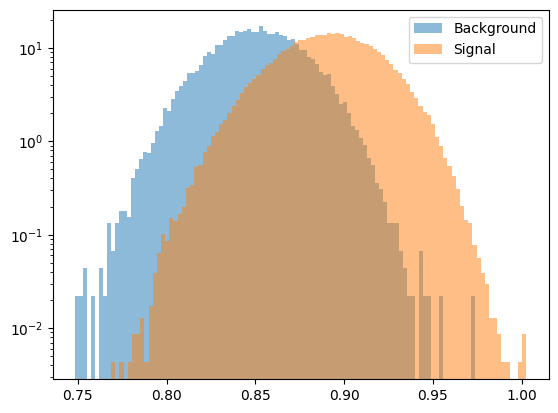

In [ ]:
plt.hist(background_test_simple, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test_simple, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

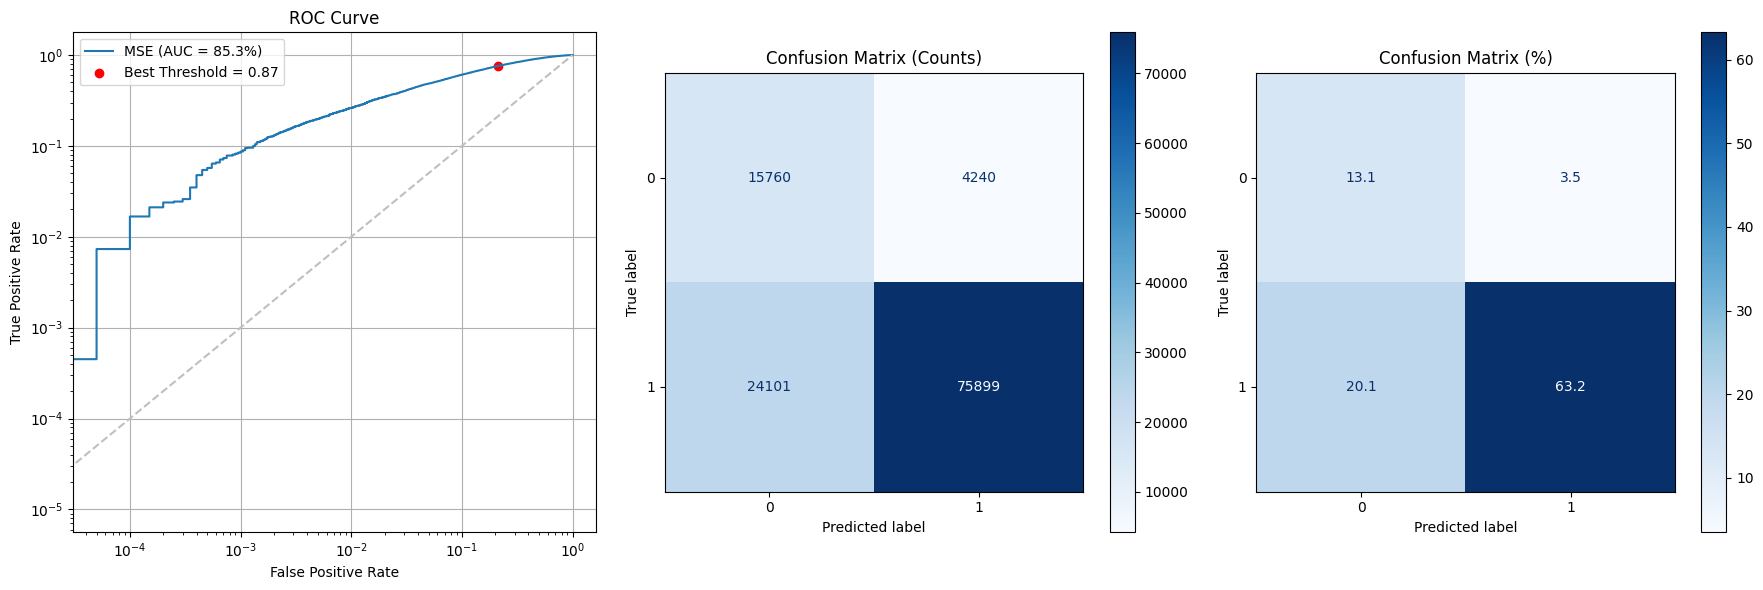

In [ ]:
make_plot_roc_curves(background_test_simple, signal_test_simple)

## Utilizando Optuna para optimizar un Autoencoder

In [ ]:
x_train_detector1 = x_train[:,:,0]
x_train_detector2 = x_train[:,:,1]
print(x_train_detector1.shape, x_train_detector2.shape)
x_train_mixed = np.vstack((x_train_detector1, x_train_detector2))

x_test_detector1 = x_test[:,:,0]
x_test_detector2 = x_test[:,:,1]
x_test_mixed = np.vstack((x_test_detector1, x_test_detector2))
x_test_mixed.shape

(80000, 200) (80000, 200)


(40000, 200)

In [ ]:
def mix_detector_series(x_train):
    x_train_detector1 = x_train[:,:,0]
    x_train_detector2 = x_train[:,:,1]
    return np.vstack((x_train_detector1, x_train_detector2))

In [ ]:
bbh_mixed = mix_detector_series(bbh)

In [ ]:
class SimpleAutoencoder:
    def __init__(self, input_shape, encoding_dim, learning_rate):
        self.input_shape = input_shape
        self.encoding_dim = encoding_dim
        self.learning_rate = learning_rate

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)

        # Encoder
        x = layers.Flatten()(inputs)
        x = layers.Dense(self.encoding_dim, activation="relu")(x)

        # Decoder
        x = layers.Dense(np.prod(self.input_shape), activation=None)(x)
        outputs = layers.Reshape(self.input_shape)(x)  # Reshape to match input shape

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate))

    def fit(self, x_train, validation_split=0.2, epochs=100, batch_size=32):
        history = self.ae.fit(
            x_train, x_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=0
        )
        return history

    def predict(self, X):
        reconstructed = self.ae.predict(X)
        return np.mean((reconstructed - X) ** 2, axis=1)

In [ ]:
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameter search space
    encoding_dim = trial.suggest_int("encoding_dim", 10, 128)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    # Initialize and build model
    autoencoder = SimpleAutoencoder(input_shape=x_train_mixed.shape[1:],
                                    encoding_dim=encoding_dim,
                                    learning_rate=learning_rate
                                   )
    autoencoder.build_model()

    # Fit model and evaluate validation loss
    history = autoencoder.fit(x_train_mixed, validation_split=0.2, epochs=100, batch_size=batch_size)
    val_loss = min(history.history["val_loss"])

    return val_loss

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15)

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2024-11-12 06:47:54,214] A new study created in memory with name: no-name-30acbb47-e5d2-47ff-8e34-cbb3c572d950
/tmp/ipykernel_612103/3703604765.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-6, 1e-3)
[I 2024-11-12 06:49:28,837] Trial 0 finished with value: 0.5592848658561707 and parameters: {'encoding_dim': 46, 'learning_rate': 0.00019645045266126901, 'batch_size': 16}. Best is trial 0 with value: 0.5592848658561707.
[I 2024-11-12 06:50:56,873] Trial 1 finished with value: 0.5340566039085388 and parameters: {'encoding_dim': 49, 'learning_rate': 6.540044592502452e-05, 'batch_size': 64}. Best is trial 1 with value: 0.5340566039085388.
[I 2024-11-12 06:52:16,437] Trial 2 finished with value: 0.3575330972671509 and parameters: {'encoding_dim': 74, 'learning_rate':

Best hyperparameters: {'encoding_dim': 127, 'learning_rate': 0.0009095469183195417, 'batch_size': 32}


In [ ]:
# Train final model with best hyperparameters
autoencoder = SimpleAutoencoder(input_shape=x_train_mixed.shape[1:],
                                encoding_dim=127,
                                learning_rate=0.0009095469183195417
                               )
autoencoder.build_model()
autoencoder.fit(x_train_mixed, validation_split=0.2, epochs=100, batch_size=32)

In [ ]:
x_train_mixed.shape, x_test_mixed.shape

((160000, 200), (40000, 200))

In [ ]:
# evaluate on test background and signal samples
background_test_simple = autoencoder.predict(x_test_mixed)
signal_test_simple = autoencoder.predict(bbh_mixed)

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
6250/6250 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


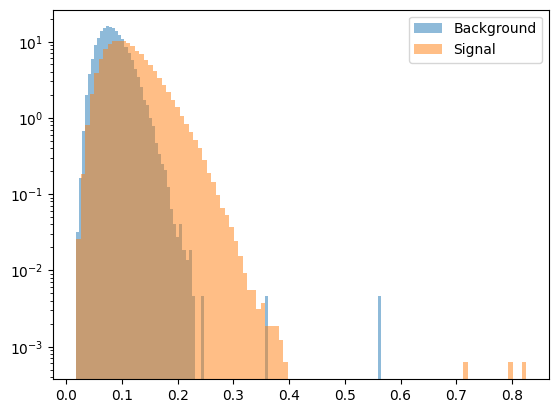

In [ ]:
plt.hist(background_test_simple, density=True, bins=100, alpha=0.5, label='Background')
plt.hist(signal_test_simple, density=True, bins=100, alpha=0.5, label='Signal')
plt.semilogy()
plt.legend()

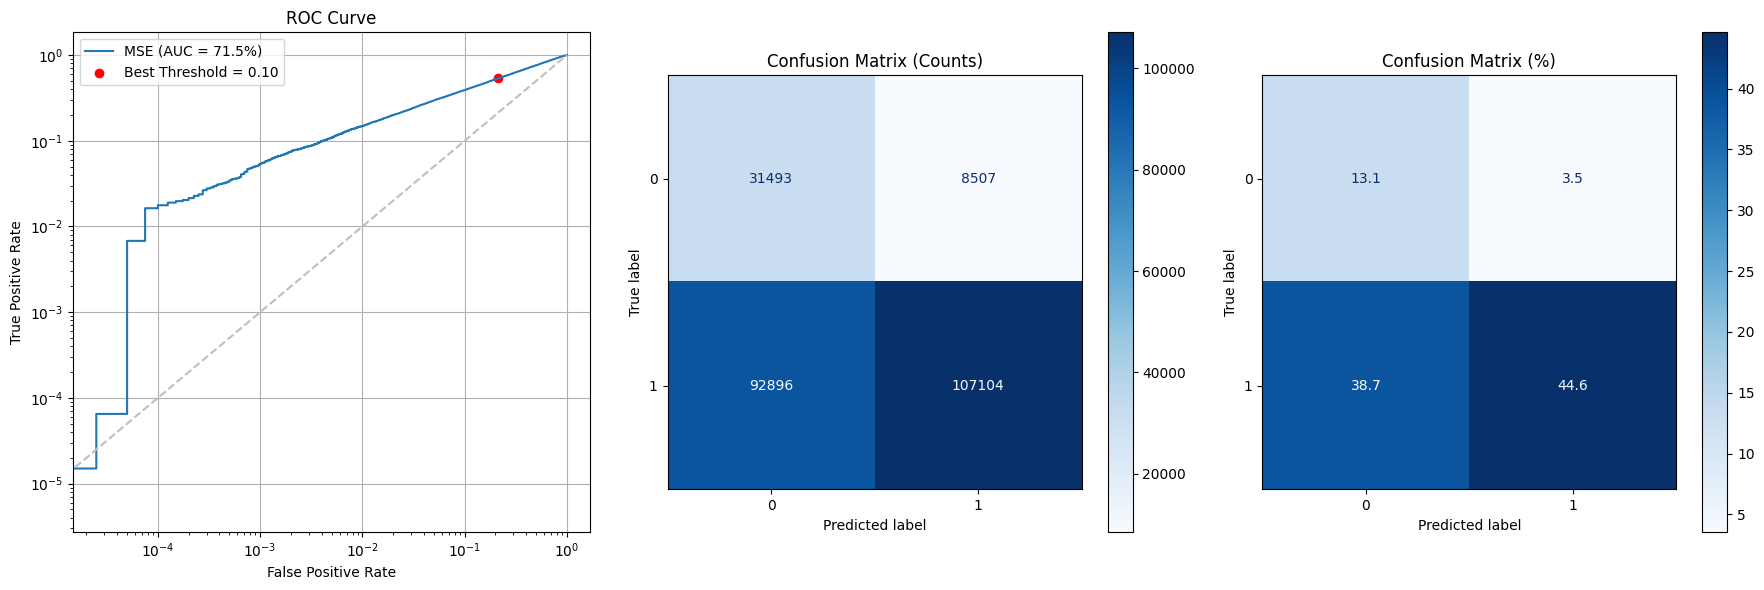

In [ ]:
def make_plot_roc_curves(qcd, bsm):
    # True labels and predicted values
    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    # ROC Curve
    fpr_loss, tpr_loss, thresholds = roc_curve(true_val, pred_val)
    auc_loss = auc(fpr_loss, tpr_loss)

    # Find the best threshold by maximizing Youden's J statistic (TPR - FPR)
    j_scores = tpr_loss - fpr_loss
    best_threshold_index = np.argmax(j_scores)
    best_threshold = thresholds[best_threshold_index]

    # Apply best threshold to convert predictions to binary
    pred_binary = (pred_val >= best_threshold).astype(int)

    # Confusion Matrix (Counts and Percentages)
    cm = confusion_matrix(true_val, pred_binary)
    cm_percent = cm.astype('float') / cm.sum() * 100  # Normalize to percentages

    # Plot ROC Curve
    plt.figure(figsize=(18, 6))

    # ROC Curve plot
    plt.subplot(1, 3, 1)
    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (AUC = {auc_loss*100:.1f}%)', linewidth=1.5)
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')
    plt.scatter(fpr_loss[best_threshold_index], tpr_loss[best_threshold_index], color='red', label=f'Best Threshold = {best_threshold:.2f}')
    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.title('ROC Curve')

    # Confusion Matrix (Counts)
    plt.subplot(1, 3, 2)
    ConfusionMatrixDisplay(cm, display_labels=["0", "1"]).plot(cmap="Blues", values_format="d", ax=plt.gca())
    plt.title(f'Confusion Matrix (Counts)')

    # Confusion Matrix (Percentages)
    plt.subplot(1, 3, 3)
    ConfusionMatrixDisplay(cm_percent, display_labels=["0", "1"]).plot(cmap="Blues", values_format=".1f", ax=plt.gca())
    plt.title(f'Confusion Matrix (%)')

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

make_plot_roc_curves(background_test_simple, signal_test_simple)

In [ ]:
class SimpleAutoencoder:
    def __init__(self, input_shape, encoding_dim):
        self.input_shape = input_shape
        self.encoding_dim = encoding_dim
        #self.learning_rate = learning_rate

    def build_model(self):
        inputs = keras.Input(shape=self.input_shape)

        # Encoder
        x = layers.Flatten()(inputs)
        x = layers.Dense(self.encoding_dim, activation="relu")(x)

        # Decoder
        x = layers.Dense(np.prod(self.input_shape), activation=None)(x)
        outputs = layers.Reshape(self.input_shape)(x)  # Reshape to match input shape

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam())

    def fit(self, x_train, validation_split=0.2, epochs=100, batch_size=32):
        history = self.ae.fit(
            x_train, x_train,
            validation_split=validation_split,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
            verbose=0
        )
        return history

    def predict(self, X):
        reconstructed = self.ae.predict(X)
        return np.mean((reconstructed - X) ** 2, axis=1)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Define el objetivo de optimización
def objective(trial):
    # Sugerir el valor del hiperparámetro `encoding_dim`
    encoding_dim = trial.suggest_int("encoding_dim", 50, 180, step=10)

    # Construir el autoencoder con el valor actual de `encoding_dim`
    simple_autoencoder = SimpleAutoencoder(input_shape=(200, 1), encoding_dim=encoding_dim)
    simple_autoencoder.build_model()

    # Entrenar el autoencoder con los datos de entrenamiento
    history = simple_autoencoder.fit(
        x_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
       # callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
     #   verbose=0  # Reducir el ruido de los logs
    )

    # Evaluar el rendimiento utilizando el conjunto de validación
    val_loss = min(history.history["val_loss"])
    return val_loss

# Crear el estudio de Optuna
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)  # Ejecutar 20 experimentos

# Mostrar los resultados del mejor hiperparámetro encontrado
print("Best encoding_dim:", study.best_params["encoding_dim"])
print("Best validation loss:", study.best_value)

# Puedes usar el mejor valor para construir un modelo final
best_encoding_dim = study.best_params["encoding_dim"]
final_autoencoder = SimpleAutoencoder()
final_autoencoder.build_model(input_shape=input_shape, encoding_dim=best_encoding_dim)
final_autoencoder.fit(
    x_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
   # callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)


[I 2024-11-28 14:14:22,395] A new study created in memory with name: no-name-db232552-5a5f-4d03-a2a4-2203426f3f6f
[W 2024-11-28 14:14:25,813] Trial 0 failed with parameters: {'encoding_dim': 180} because of the following error: ValueError('Exception encountered when calling Functional.call().\n\n\x1bInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 200, but received input with shape (32, 400)\x1b\n\nArguments received by Functional.call():\n  • inputs=tf.Tensor(shape=(32, 200, 2), dtype=float32)\n  • training=True\n  • mask=None').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-47-51218b9ecc36>", line 17, in objective
    history = simple_autoencoder.fit(
  File "<ipython-input-41-b4daaed0b460>", line 22, in fit
    history = self.ae.fit(
  File "/usr/local/lib/python3.10/dist-packages/ker

ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "dense_8" is incompatible with the layer: expected axis -1 of input shape to have value 200, but received input with shape (32, 400)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(32, 200, 2), dtype=float32)
  • training=True
  • mask=None

# **Conclusiones**


En este trabajo se ha realizado una exploración de modelos de aprendizaje supervisado y no supervisado para la detección de ondas gravitacionales. Estos métodos predictivos son útiles en muchas areas de la actualidad y se investiga la performance de estos modelos en este ámbito.

En particular se utilizó dos tipos de datos: de background y ondas un sistema de BBH sobre background.

Se comenzó con un estudio del dataset averiguando las componentes principales, a partir de PCA. Se puede ver cierta redundancia de los datos y se puede en el futuro probar con modelos de dimension aproximada a 170, en lugar de las 200 que disponen los datos del dataset.

Se comenzó haciendo un análisis con modelos supervisados: KNN, Random Forest, Redes Convolucionales y YOLO, donde se utilizó como baselines a KNN y Random Forest.

Como cada detector tiene distinto ruido y la señal tiene una demora de llegar de un detector al otro, se ha probado dos enfoques distintos al entrenar con KNN y Random Forest.
Por un lado se ha entrenado un modelo por detector, y por otro, se ha entrenado un único modelo con todas las señales.

En el caso de un KNN para cada detector, se ha obtenido una accuracy de 0.93, y en el caso de un único KNN, se ha obtenido un accuracy de 0.86. Para el caso de un Random Forest para cada detector, se ha obtenido un accuracy de 0.83, y en el caso de un único Random Forest se ha obtenido un accuracy de 0.88. Por lo tanto al momento no podemos asumir que usar un modelo para cada detector es una mejor opción.

Se ha utilizado Optuna para realizar un ajuste de hiperparáemtros de una red convolucional 1D, ya que contamos con datos que son series temporales, y se ha obtenido 0.97 de accuracy.

En cuanto a algoritmos supervisados, por último se ha utilizado al modelo YOLO para clasificación. Para lograr esto, se ha obtenido un espectrograma para cada señal, el cual se ha utilizado para entrenamiento. En este caso se ha utilizado únicamente 5000 imágenes de cada una de las dos clases para entrenamiento y validación por cuestiones computacionales. Se ha entrenado hasta 100 epochs y se ha obtenido un accuracy de 0.96.

En lo que respecta a aprendizaje no supervisado, se ha utilizado Autoencoders en conjunto con la librería Optuna para optimizar sus hiperparámetros.

Con un transformer, sin búsqueda de hiperparámetros, se ha obtenido 0.70 de accuracy. Este modelo ha sido provisto por la competencia de donde se obtienen los datos y se utiliza en este caso de benchmark.

Se ha entrenado un Autoencoder con una capa oculta de dimensión 64 y se ha obtenido un accuracy de 0.76. También se ha realizado una búsqueda de hiperparámetros con Optuna para nuevos autoencoders y se ha logrado una accuracy de 0.57. En este caso es factible que se obtengan mejores resultados realizando un entrenamiento mas extenso, tanto en epochs, como una búsqueda de hiperparámetros más grande.

A partir de las matrices de confusión se puede ver que los modelos supervisados han obtenido mejores resultados, aunque como ya se ha comentado, estos modelos pueden no ser precisos al momento de detectar ondas gravitacionales de características distintas a las provenientes de sistemas binarios de agujeros negros.

Se planea continuar el trabajo entrenando los modelos más intensivamente, y en caso de YOLO, utilizar todo el dataset completo a través de mayor capacidad de cómputo. También se puede evaluar obtener espectrogramas de otra manera que pueda ayudar al entrenamiento.

Actualmente se está usando 2 clases y se puede agregar una tercera, con ondas seno-gaussias, disponibles en el dataset del challenge.

Además se puede utilizar PCA como preprocesamiento para entrenar modelos con componentes principales.

El proyecto ha servido para observar la performance de diferentes métodos para detectar ondas gravitacionales. Se considera que con lo realizado actualmente queda margen de mejora de entrenamiento de los modelos. Se ha obtenido un mejor modelo no supervisado que el benchmark del challenge, pero se considera que hay posibilidad de mejora, debido a que el modelo que lo supera es un Autoencoder de una capa oculta, y con un modelo de mayor expresividad se puede lograr mejores resultados.

# **Bibliografía**

- [Challenge](https://www.codabench.org/competitions/2626/)
- [GWAK: Gravitational-Wave Anomalous Knowledge
with Recurrent Autoencoders](https://arxiv.org/pdf/2309.11537)
- [Anomaly detection in gravitational waves data
using convolutional autoencoders](https://iopscience.iop.org/article/10.1088/2632-2153/abf3d0/pdf)

- [Gwak PDF](https://indico.cern.ch/event/1283970/contributions/5550652/attachments/2722055/4729304/gwak.pdf)
- [ML4GW Gwak GitHub](https://github.com/ML4GW/gwak)
- [A3D3 Article](https://a3d3.ai/a-recipe-to-find-anomalies-enhancing-gravitational-wave-detection-with-deep-recurrent-autoencoders/)
- [Machine Learning for Transient Noise Event Classification (LIGO & Virgo)](https://indico.cern.ch/event/658267/papers/2868647/files/8356-Machine_Learning_for_transient_noise_event_classification_in_LIGO_and_Virgo.pdf)
- [Quasi Anomalous Knowledge: Searching for new
physics with embedded knowledge](https://arxiv.org/pdf/2011.03550)
